# Analysis on secure logs

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import Reader
import ParamsExtractor3
import DataPreprocessor
import DeepLearningAnomalyDetection2

2024-07-10 15:12:18.847994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 15:12:18.848571: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 15:12:18.851910: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 15:12:18.896071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 15:12:19.685628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Training

In [4]:
log_types = ['secure']
dates = ['20240418', '20240420', '20240429']
login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    df_list.append(df)

['/../../../temp_logs/20240418/login01.secure.log', '/../../../temp_logs/20240418/login02.secure.log', '/../../../temp_logs/20240418/login03.secure.log', '/../../../temp_logs/20240418/login10.secure.log', '/../../../temp_logs/20240420/login01.secure.log', '/../../../temp_logs/20240420/login02.secure.log', '/../../../temp_logs/20240420/login03.secure.log', '/../../../temp_logs/20240420/login10.secure.log']


In [5]:
len(df_list)

8

In [6]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor3.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)
    df_list[i] = pd.concat([df_list[i], new_df], axis=1)

File 'log_key.json' does not exist. Creating a new file.


In [7]:
df_list[0].head()

host    ident    pid                                            message  \
0  login01  systemd  37690  pam_unix(systemd-user:session): session opened...   
1  login01     sshd  37759  Accepted publickey for root from 10.44.0.12 po...   
2  login01     sshd  37759  pam_unix(sshd:session): session opened for use...   
3  login01     sshd  37765  Received disconnect from 10.44.0.12 port 44266...   
4  login01     sshd  37765  Disconnected from user root 10.44.0.12 port 44266   

  severity  facility                       time  severity_numbers  \
0     info  authpriv  2024-04-18 00:00:01 +0200                 6   
1     info  authpriv  2024-04-18 00:00:02 +0200                 6   
2     info  authpriv  2024-04-18 00:00:02 +0200                 6   
3     info  authpriv  2024-04-18 00:00:02 +0200                 6   
4     info  authpriv  2024-04-18 00:00:02 +0200                 6   

   facility_numbers  severity_scores  timedelta          ip   port session  \
0                10              1.0        0.0          -1     -1  opened   
1                10              1.0        1.0  10.44.0.12  44266      -1   
2                10              1.0        0.0          -1     -1  opened   
3                10              1.0        0.0  10.44.0.12  44266      -1   
4                10              1.0        0.0  10.44.0.12  44266      -1   

   log key  log key spell  n_dang  n_dang_no_cron  fp_length  
0        0             -1      -1              -1          1  
1        1             52       0               0          2  
2        0             -1      -1              -1          1  
3        2             -1      -1              -1          1  
4        3             55      -1              -1          1

In [8]:
for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    df_list[i] = enc

print(df_list[0].head())

   severity_scores  timedelta   port  log key  log key spell  n_dang  \
0              1.0        0.0     -1        0             -1      -1   
1              1.0        1.0  44266        1             52       0   
2              1.0        0.0     -1        0             -1      -1   
3              1.0        0.0  44266        2             -1      -1   
4              1.0        0.0  44266        3             55      -1   

   n_dang_no_cron  fp_length  col_0  col_1  ...  col_10  col_11  col_12  \
0              -1          1      0      0  ...       0       0       3   
1               0          2      1      0  ...       0       1       1   
2              -1          1      1      0  ...       0       1       2   
3              -1          1      1      0  ...       0       0       1   
4              -1          1      1      0  ...       0       0       1   

   col_13  col_14  col_15  col_16  col_17  col_18  col_19  
0       0       0       0       1       0       0       

In [9]:
for df in df_list:
    print(df.shape)

(1000, 28)
(1000, 28)
(1000, 28)
(1000, 28)
(1000, 28)
(1000, 28)
(1000, 28)
(1000, 28)


In [10]:
normal_dataset = df_list[0]

for i in range(1,len(df_list)):
    normal_dataset = np.vstack([normal_dataset, df_list[i]])

In [11]:
normal_dataset.shape

(8000, 28)

## Anomalies' dataset

In [12]:
log_types = ['secure']

# Generate the list of file paths
file_paths = [f'../data/linpeas_logs_1/{logtype}_logs.log' for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]

an_df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file_2(file_path)
    an_df_list.append(df)

In [13]:
an_df_list[0].head()

host        ident   pid  \
0  localhost  sudo[3680]:  3680   
1  localhost  sudo[3680]:  3680   
2  localhost  sudo[3680]:  3680   
3  localhost  sudo[3693]:  3693   
4  localhost  sudo[3693]:  3693   

                                             message severity  facility  \
0    matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...   notice  authpriv   
1  pam_unix(sudo:session): session opened for use...     info  authpriv   
2  pam_unix(sudo:session): session closed for use...     info  authpriv   
3    matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...   notice  authpriv   
4  pam_unix(sudo:session): session opened for use...     info  authpriv   

                               time  
0  2024-06-22T11:55:39.520333-04:00  
1  2024-06-22T11:55:39.526046-04:00  
2  2024-06-22T11:55:39.974240-04:00  
3  2024-06-22T11:55:46.643379-04:00  
4  2024-06-22T11:55:46.655326-04:00

In [14]:
an_df_after = []

for i, df in enumerate(an_df_list):
    p = ParamsExtractor3.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    an_df_after.append(new_df)
    an_df_list[i] = pd.concat([an_df_list[i], new_df], axis=1)

In [15]:
an_df_list[0].head()

host        ident   pid  \
0  localhost  sudo[3680]:  3680   
1  localhost  sudo[3680]:  3680   
2  localhost  sudo[3680]:  3680   
3  localhost  sudo[3693]:  3693   
4  localhost  sudo[3693]:  3693   

                                             message severity  facility  \
0    matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...   notice  authpriv   
1  pam_unix(sudo:session): session opened for use...     info  authpriv   
2  pam_unix(sudo:session): session closed for use...     info  authpriv   
3    matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...   notice  authpriv   
4  pam_unix(sudo:session): session opened for use...     info  authpriv   

                               time  severity_numbers  facility_numbers  \
0  2024-06-22T11:55:39.520333-04:00                 5                10   
1  2024-06-22T11:55:39.526046-04:00                 6                10   
2  2024-06-22T11:55:39.974240-04:00                 6                10   
3  2024-06-22T11:55:46.643379-04:00                 5                10   
4  2024-06-22T11:55:46.655326-04:00                 6                10   

   severity_scores  timedelta  ip port session  log key  log key spell  \
0         2.718282   0.000000  -1   -1      -1       56             -1   
1         1.000000   0.005713  -1   -1  opened       57             -1   
2         1.000000   0.448194  -1   -1  closed        4             53   
3         2.718282   6.669139  -1   -1      -1       58             56   
4         1.000000   0.011947  -1   -1  opened       57             -1   

   n_dang  n_dang_no_cron  fp_length  
0       1               0          6  
1      -1              -1          1  
2      -1              -1          1  
3       2               0          9  
4      -1              -1          1

In [16]:
for i, df in enumerate(an_df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    an_df_list[i] = enc

print(an_df_list[0].head())

   severity_scores  timedelta port  log key  log key spell  n_dang  \
0         2.718282   0.000000   -1       56             -1       1   
1         1.000000   0.005713   -1       57             -1      -1   
2         1.000000   0.448194   -1        4             53      -1   
3         2.718282   6.669139   -1       58             56       2   
4         1.000000   0.011947   -1       57             -1      -1   

   n_dang_no_cron  fp_length  col_0  col_1  ...  col_10  col_11  col_12  \
0               0          6      1      1  ...       0       0       2   
1              -1          1      1      1  ...       0       0       2   
2              -1          1      2      1  ...       0       0       1   
3               0          9      0      0  ...       0       0       2   
4              -1          1      0      0  ...       0       0       2   

   col_13  col_14  col_15  col_16  col_17  col_18  col_19  
0       0       0       0       0       0       0       0  
1       

In [17]:
# we test secure
# we take the lines from the 230th (detected pwd bruteforcing)
anomalous_dataset = an_df_list[0][230:]

In [18]:
anomalous_dataset.shape

(770, 28)

In [19]:
anomalous_dataset.columns

Index(['severity_scores', 'timedelta', 'port', 'log key', 'log key spell',
       'n_dang', 'n_dang_no_cron', 'fp_length', 'col_0', 'col_1', 'col_2',
       'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10',
       'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17',
       'col_18', 'col_19'],
      dtype='object')

## Library implementation

In [20]:
normal_dataset_df = pd.DataFrame(normal_dataset, columns=anomalous_dataset.columns)

In [21]:
normal_dataset_reduced = normal_dataset_df[['severity_scores', 'timedelta', 'port', 'log key', 'log key spell',
       'n_dang', 'n_dang_no_cron', 'fp_length']]
anomalous_dataset_reduced = anomalous_dataset[['severity_scores', 'timedelta', 'port', 'log key', 'log key spell',
       'n_dang', 'n_dang_no_cron', 'fp_length']]

Mean normal reconstruction error: 0.0014271262909931863
Mean anomalous reconstruction error: 0.2793154853595609


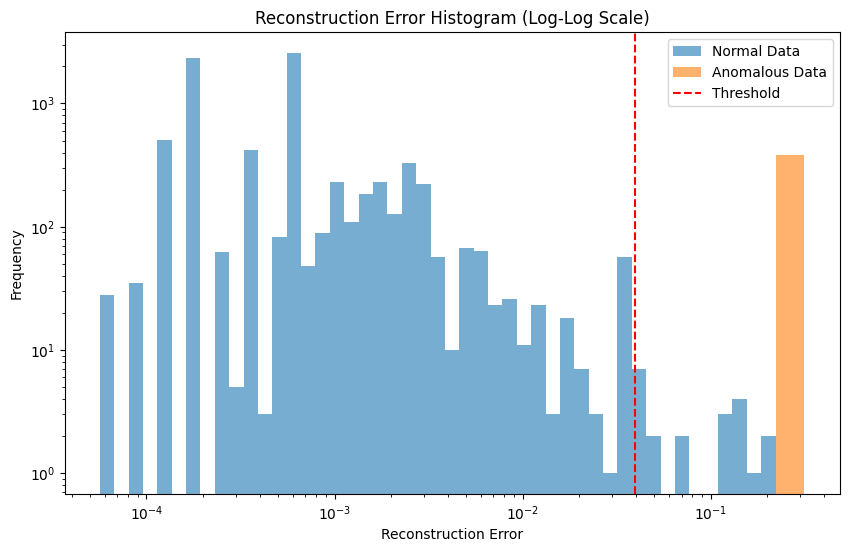

Threshold for anomaly detection: 0.03962984075319244
Number of anomalies detected: 770
Number of false positives detected: 15


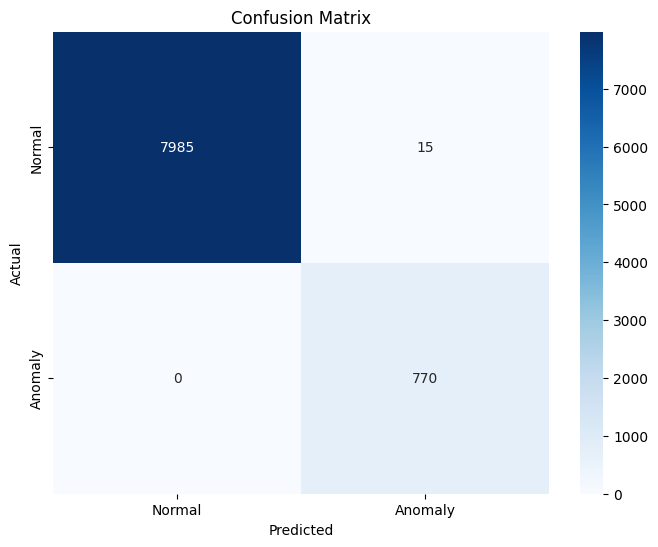

In [22]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset, 'autoencoder', plots=[0,0,1,1])

Mean normal reconstruction error: 0.010979463828802457
Mean anomalous reconstruction error: 0.95446356207233


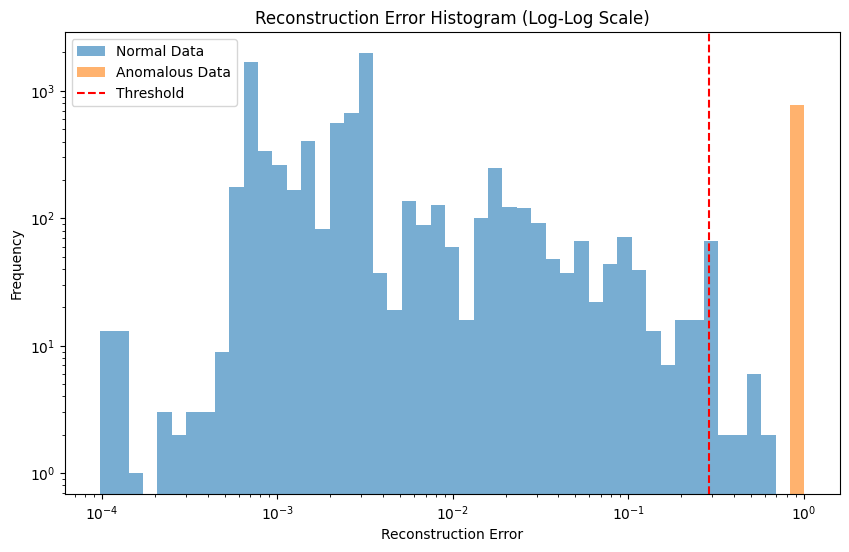

Threshold for anomaly detection: 0.2881754622087131
Number of anomalies detected: 770
Number of false positives detected: 20


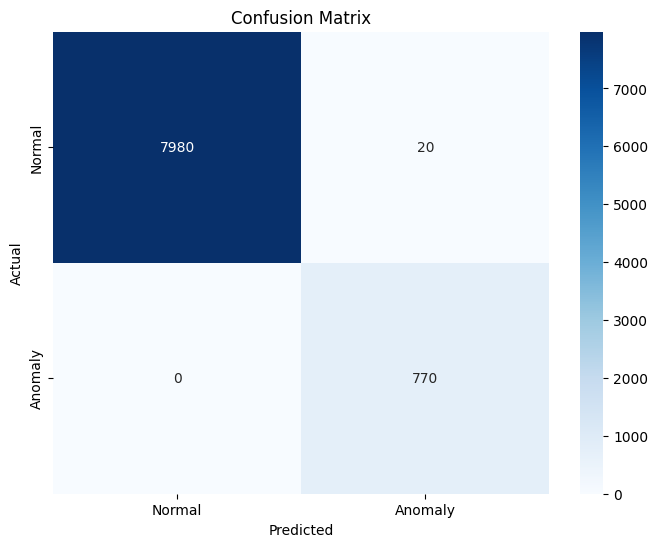

In [23]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies_vae, reconstructed_anomalies_vae, fp = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset, 'vae', plots=[0,0,1,1])

In [24]:
#analysis of false positives
print(fp)

# Find the indexes where the value is True
true_indexes = [index for index, value in enumerate(fp) if value]

# Print the indexes
print(true_indexes)

[False False False ... False False False]
[1983, 2355, 3044, 3057, 3114, 3203, 3252, 3811, 3901, 4162, 4835, 5080, 6082, 6660, 7052, 7137, 7159, 7262, 7316, 7875]


In [25]:
normal_dataset[1983]

array([20.085536923187668, 0.0, -1, 38, 67, -1, -1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=object)

## Ensemble method

In [26]:
d_an_det.ensemble_method(normal_dataset_df, anomalous_dataset, plots=[1])

ValueError: too many values to unpack (expected 2)

In [ ]:
# Example predictions from two models (replace with your actual predictions)
predictions_model1 = reconstructed_anomalies
predictions_model2 = reconstructed_anomalies_vae

# Combine predictions using logical OR (voting scheme)
combined_predictions = np.logical_and(predictions_model1, predictions_model2).astype(int)

# Example thresholding (adjust as needed)
threshold = 0.5  # Simple majority voting

# Convert to final anomaly predictions based on threshold
final_predictions = (combined_predictions >= threshold).astype(int)

# Print or use the final predictions
print("Combined Predictions:", combined_predictions)
print("Final Anomaly Predictions:", final_predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Example ground truth and predictions (replace with your actual data)
ground_truth = true_anomalies
predictions = final_predictions
            
# Calculate confusion matrix
cm = confusion_matrix(ground_truth, predictions)
            
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Normal', 'Anomaly'], 
                        yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## LSTM and time dependent models

In [64]:
cols = ['severity_scores', 'timedelta', 'log key', 'log key spell', 'n_dang', 'n_dang_no_cron', 'fp_length', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19']

Index(['severity_scores', 'timedelta', 'port', 'log key', 'log key spell',
       'n_dang', 'n_dang_no_cron', 'fp_length', 'col_0', 'col_1', 'col_2',
       'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10',
       'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17',
       'col_18', 'col_19'],
      dtype='object')

In [68]:
normal_dataset_df = normal_dataset_df.drop('port', axis=1)
normal_dataset_df.shape

(8000, 27)

In [69]:
anomalous_dataset = anomalous_dataset.drop('port', axis=1)
anomalous_dataset.shape

(770, 27)

In [70]:
normal_dataset_df.head()

severity_scores timedelta log key log key spell n_dang n_dang_no_cron  \
0             1.0       0.0       0            -1     -1             -1   
1             1.0       1.0       1            52      0              0   
2             1.0       0.0       0            -1     -1             -1   
3             1.0       0.0       2            -1     -1             -1   
4             1.0       0.0       3            55     -1             -1   

  fp_length col_0 col_1 col_2  ... col_10 col_11 col_12 col_13 col_14 col_15  \
0         1     0     0     0  ...      0      0      3      0      0      0   
1         2     1     0     0  ...      0      1      1      0      0      0   
2         1     1     0     0  ...      0      1      2      0      0      0   
3         1     1     0     0  ...      0      0      1      0      0      0   
4         1     1     0     0  ...      0      0      1      0      0      0   

  col_16 col_17 col_18 col_19  
0      1      0      0      0  
1      0      0      1      0  
2      0      0      0      0  
3      0      0      1      0  
4      0      0      1      0  

[5 rows x 27 columns]

In [71]:
# take normal_dataset_df of shape (8000, 28)
# split it into windows of (200,28) each 50 elements

# Function to create windows and targets
def create_windows_and_targets(data, window_size, prediction_size, step_size):
    windows, targets = [], []
    for i in range(0, len(data) - window_size - prediction_size + 1, step_size):
        windows.append(data.iloc[i:i + window_size].values)
        targets.append(data.iloc[i + window_size:i + window_size + prediction_size].values)
    return np.array(windows), np.array(targets)


# Define parameters
window_size = 200
prediction_size = 50
step_size = 50

# Create windows and targets
normal_windows, normal_targets = create_windows_and_targets(normal_dataset_df, window_size, prediction_size, step_size)
anomalous_windows, anomalous_targets = create_windows_and_targets(anomalous_dataset, window_size, prediction_size, step_size)

# Ensure the data is in the correct type
normal_windows = normal_windows.astype(np.float32)
normal_targets = normal_targets.astype(np.float32)
anomalous_windows = anomalous_windows.astype(np.float32)
anomalous_targets = anomalous_targets.astype(np.float32)

In [72]:
normal_windows.shape, normal_targets.shape, anomalous_windows.shape, anomalous_targets.shape

((156, 200, 27), (156, 50, 27), (11, 200, 27), (11, 50, 27))

In [73]:
# Ensure the data is in the correct type
normal_windows = normal_windows.astype(np.float32)
normal_targets = normal_targets.astype(np.float32)
anomalous_windows = anomalous_windows.astype(np.float32)
anomalous_targets = anomalous_targets.astype(np.float32)

In [74]:
# Split the last 40% of the sequences
split_idx = int(0.6 * len(normal_windows))
train_windows, train_targets = normal_windows[:split_idx], normal_targets[:split_idx]
val_test_windows, val_test_targets = normal_windows[split_idx:], normal_targets[split_idx:]

# Split the last 40% into validation and test sets (20% each of the total)
val_split_idx = int(0.5 * len(val_test_windows))
val_windows, val_targets = val_test_windows[:val_split_idx], val_test_targets[:val_split_idx]
test_windows, test_targets = val_test_windows[val_split_idx:], val_test_targets[val_split_idx:]

In [80]:
print(f"Shapes: train_windows={train_windows.shape}, train_targets={train_targets.shape}, val_windows={val_windows.shape}, val_targets={val_targets.shape}, test_windows={test_windows.shape}, test_targets={test_targets.shape}")

Shapes: train_windows=(93, 200, 27), train_targets=(93, 50, 27), val_windows=(31, 200, 27), val_targets=(31, 50, 27), test_windows=(32, 200, 27), test_targets=(32, 50, 27)


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Cropping1D
from tensorflow.keras.models import Model

def build_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = Input(shape=input_shape, name='input_layer')

    # Add an LSTM layer
    x = LSTM(64, return_sequences=True, name='lstm')(input_layer)

    # Add a Dense layer to match the desired output shape
    x = Dense(output_shape[1], name='dense')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = x.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = Cropping1D((0, crop_size), name='cropping')(x)

    # Construct the model by connecting input and output layers
    model = Model(inputs=input_layer, outputs=output_layer, name='LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

# Define the input and output shapes
input_shape = (200, 27)
output_shape = (50, 27)

# Build the model
model = build_LSTM_model(input_shape, output_shape)

# Print the model summary
model.summary()

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 27)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 64)        │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200, 27)        │         1,755 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping (Cropping1D)           │ (None, 50, 27)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,307 (98.86 KB)

 Trainable params: 25,307 (98.86 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_windows, train_targets, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(val_windows, val_targets))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 74.2278 - val_loss: 63.6314
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 73.1849 - val_loss: 62.7692
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 72.2279 - val_loss: 61.9678
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 71.3202 - val_loss: 61.1998
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 70.4304 - val_loss: 60.4377
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 69.5394 - val_loss: 59.6621
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 68.6303 - val_loss: 58.8473
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 67.6858 - val_loss: 57.9857
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 66.7032 - val_loss: 57.0850
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 65.6901 - val_loss: 56.1598
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 64.6571 - val_loss: 55.2250
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 63.6

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model_and_plot_histograms(model, test_windows, test_targets, anomalous_windows, anomalous_targets):
    # Evaluate the model on the test set (normal dataset)
    test_predictions = model.predict(test_windows)
    mae_normal = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    mse_normal = mean_squared_error(test_targets.flatten(), test_predictions.flatten())

    # Evaluate the model on the anomalous dataset
    anomalous_predictions = model.predict(anomalous_windows)
    mae_anomalous = mean_absolute_error(anomalous_targets.flatten(), anomalous_predictions.flatten())
    mse_anomalous = mean_squared_error(anomalous_targets.flatten(), anomalous_predictions.flatten())

    # Plot the MAE and MSE as histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(['Normal', 'Anomalous'], [mae_normal, mae_anomalous])
    plt.title('Mean Absolute Error')
    plt.subplot(1, 2, 2)
    plt.bar(['Normal', 'Anomalous'], [mse_normal, mse_anomalous])
    plt.title('Mean Squared Error')
    plt.tight_layout()
    plt.show()

    # Print the metrics
    print(f"MAE Normal: {mae_normal}")
    print(f"MSE Normal: {mse_normal}")
    print(f"MAE Anomalous: {mae_anomalous}")
    print(f"MSE Anomalous: {mse_anomalous}")

    return mae_normal, mse_normal, mae_anomalous, mse_anomalous

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


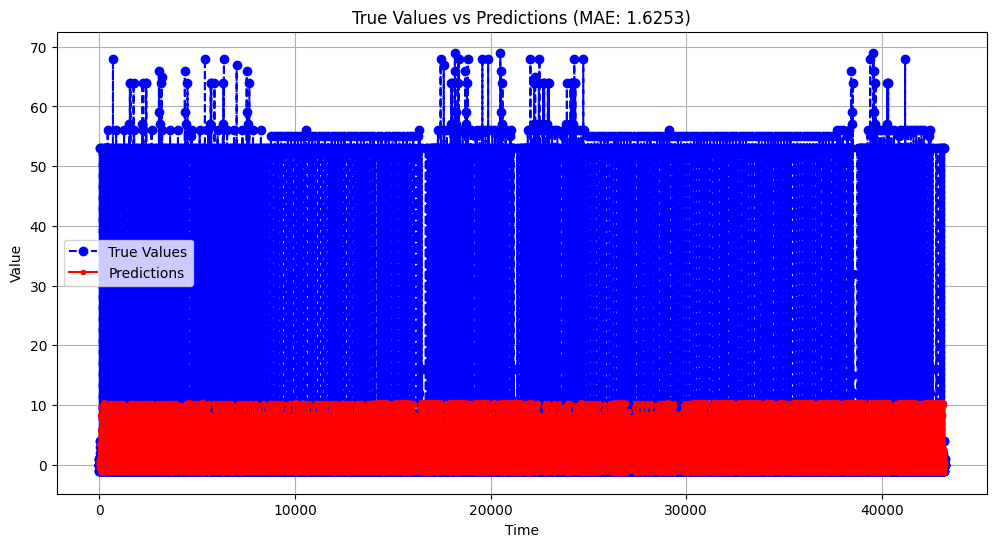

MAE Normal: 1.6253012418746948
MSE Normal: 48.43460464477539
MAE Anomalous: 4.502017974853516
MSE Anomalous: 359.78497314453125


(1.6253012, 48.434605, 4.502018, 359.78497)

In [93]:
# Assuming model, test_windows, test_targets, anomalous_windows, anomalous_targets, prediction_size are defined appropriately
evaluate_model_and_plot_mae(model, test_windows, test_targets, anomalous_windows, anomalous_targets)

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model_and_plot_per_window(model, test_windows, test_targets):
    num_windows = len(test_windows)
    for i in range(num_windows):
        # Evaluate the model on the current test window
        test_predictions = model.predict(test_windows[i:i+1])
        mae = mean_absolute_error(test_targets[i].flatten(), test_predictions.flatten())
        mse = mean_squared_error(test_targets[i].flatten(), test_predictions.flatten())

        # Plot true values vs predicted values for the current test window
        plt.figure(figsize=(10, 6))
        plt.plot(test_targets[i].flatten(), label='True Values', linestyle='--', marker='o', color='b')
        plt.plot(test_predictions.flatten(), label='Predictions', linestyle='-', marker='.', color='r')
        plt.title(f'Test Window {i+1} (MAE: {mae:.4f}, MSE: {mse:.4f})')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print the metrics for the current test window
        print(f"Test Window {i+1}:")
        print(f"  MAE: {mae}")
        print(f"  MSE: {mse}")
        print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


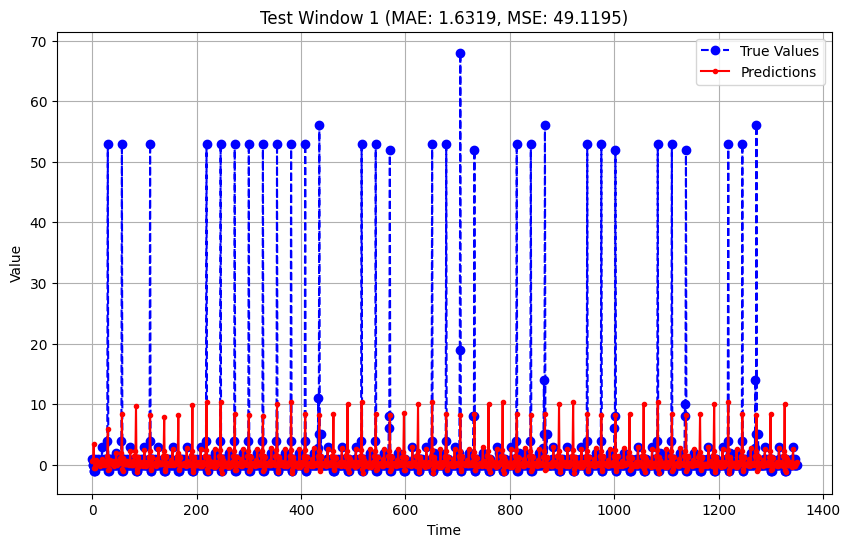

Test Window 1:
  MAE: 1.631862759590149
  MSE: 49.11945724487305
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


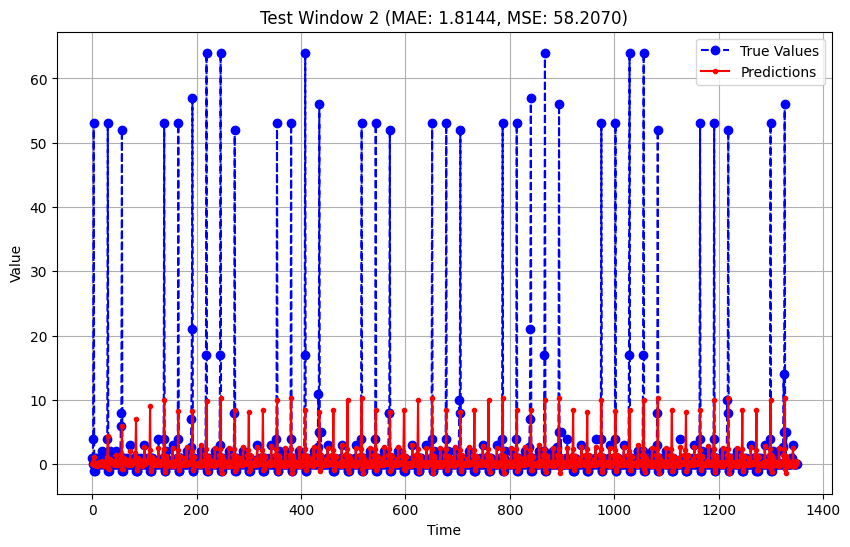

Test Window 2:
  MAE: 1.814355492591858
  MSE: 58.20698547363281
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


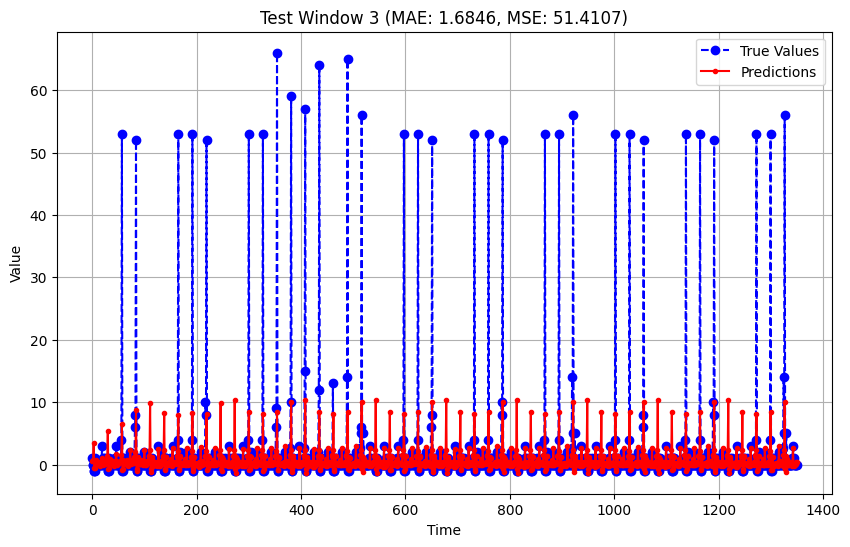

Test Window 3:
  MAE: 1.6845952272415161
  MSE: 51.41071319580078
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


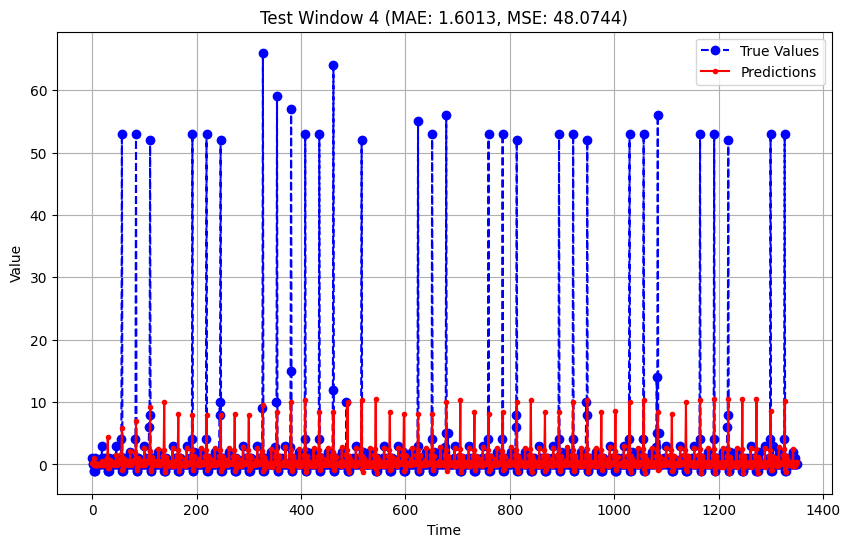

Test Window 4:
  MAE: 1.6013137102127075
  MSE: 48.074440002441406
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


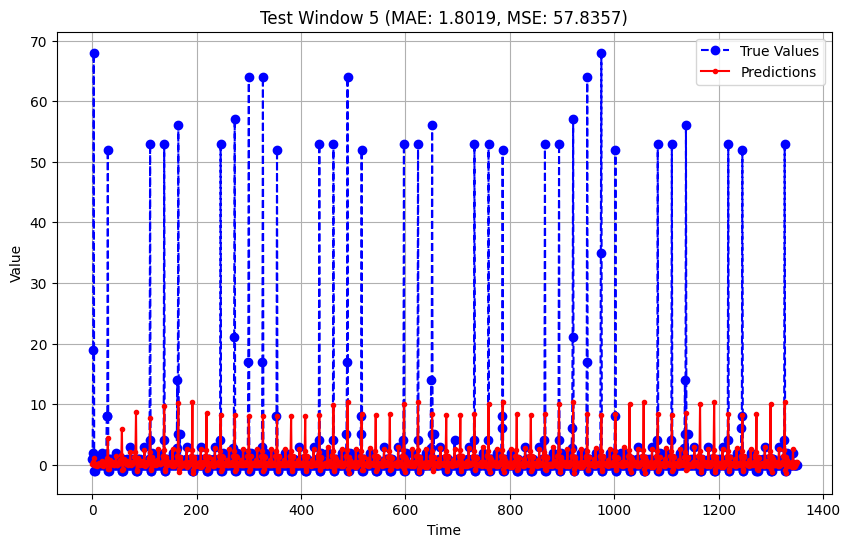

Test Window 5:
  MAE: 1.8019437789916992
  MSE: 57.83565902709961
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


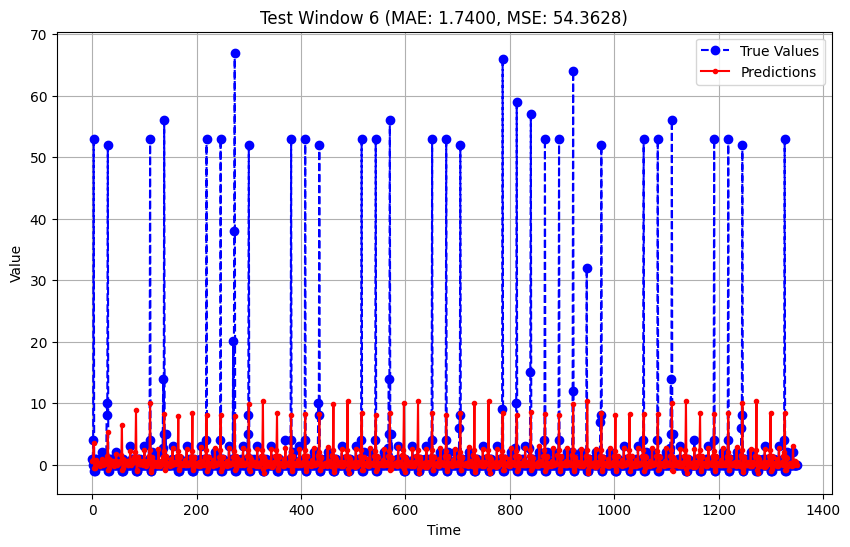

Test Window 6:
  MAE: 1.7399941682815552
  MSE: 54.36280059814453
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


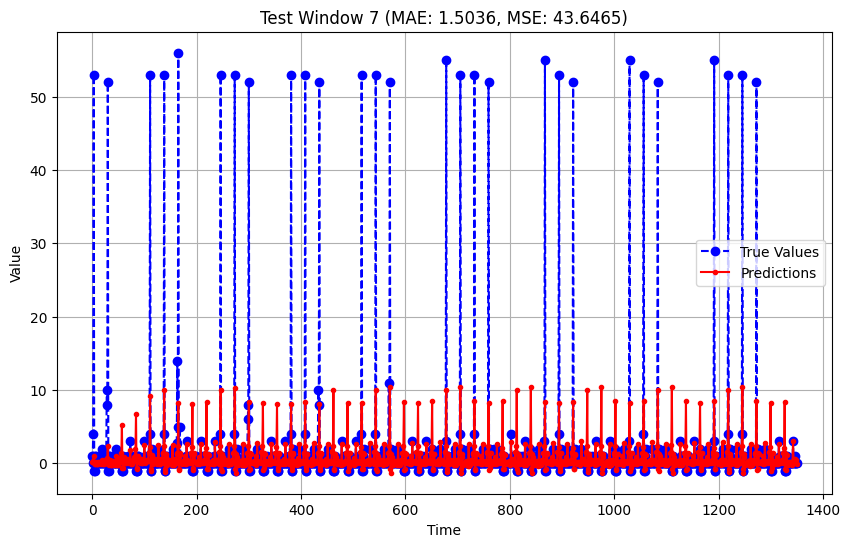

Test Window 7:
  MAE: 1.5036295652389526
  MSE: 43.64653015136719
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


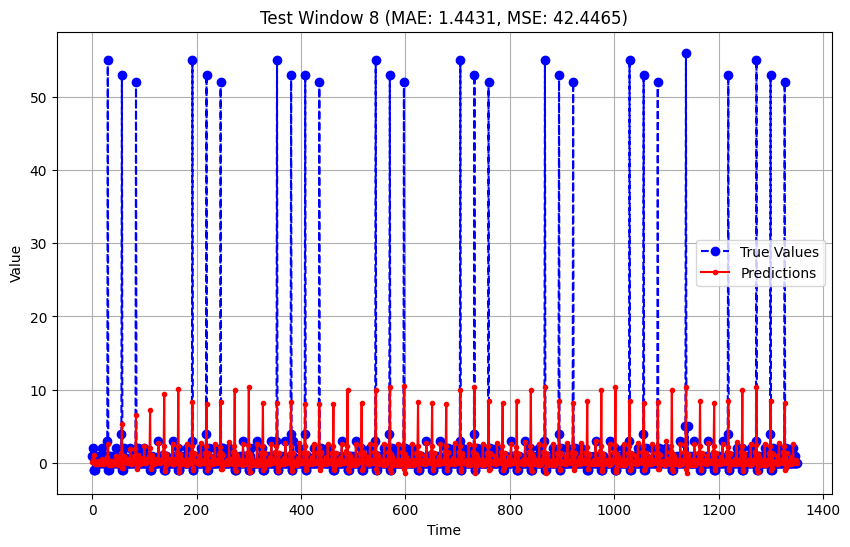

Test Window 8:
  MAE: 1.4431320428848267
  MSE: 42.446537017822266
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


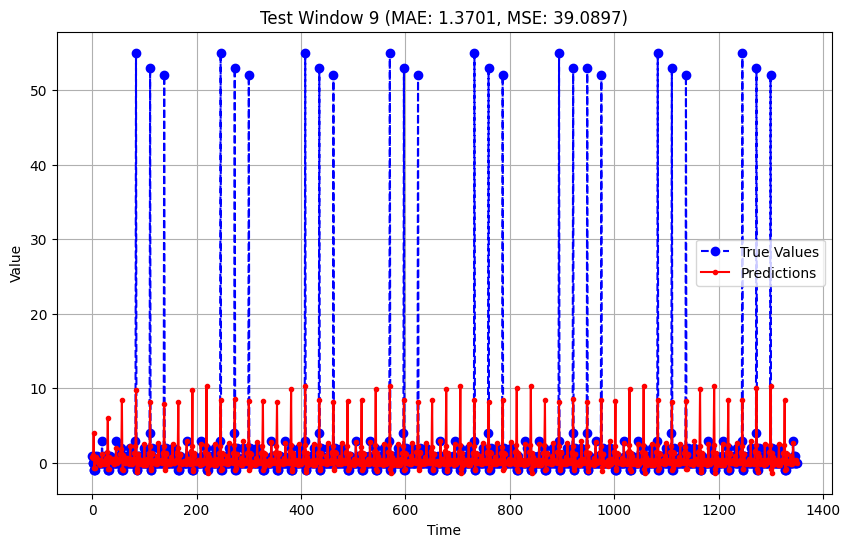

Test Window 9:
  MAE: 1.3701210021972656
  MSE: 39.08969497680664
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


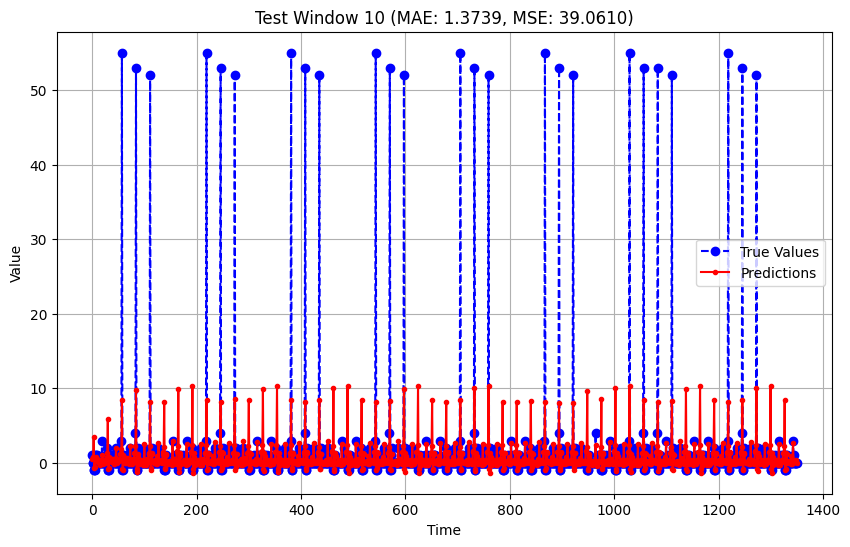

Test Window 10:
  MAE: 1.3739430904388428
  MSE: 39.060977935791016
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


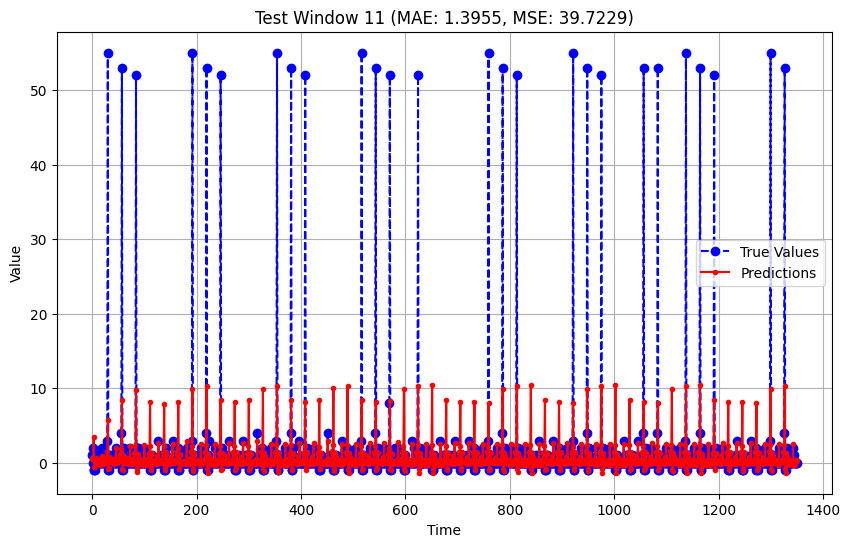

Test Window 11:
  MAE: 1.3955343961715698
  MSE: 39.72294998168945
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


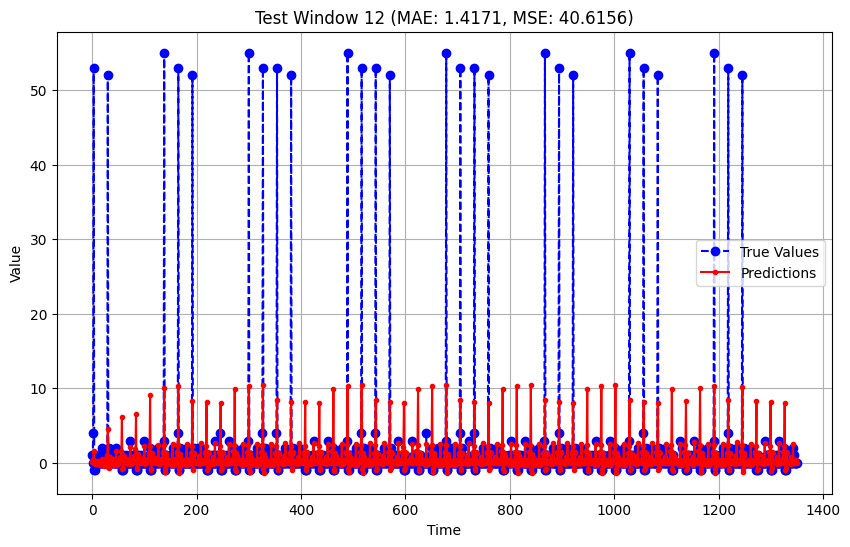

Test Window 12:
  MAE: 1.4171264171600342
  MSE: 40.6156120300293
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


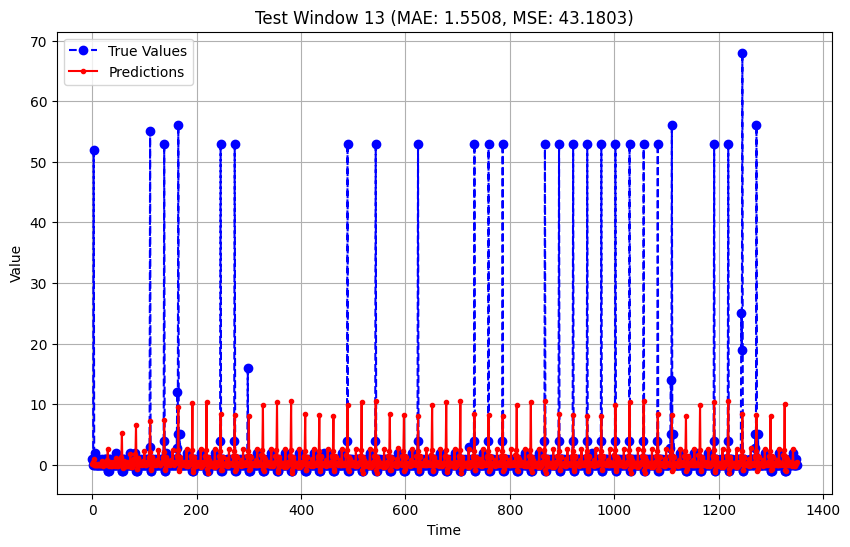

Test Window 13:
  MAE: 1.5508040189743042
  MSE: 43.18031692504883
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


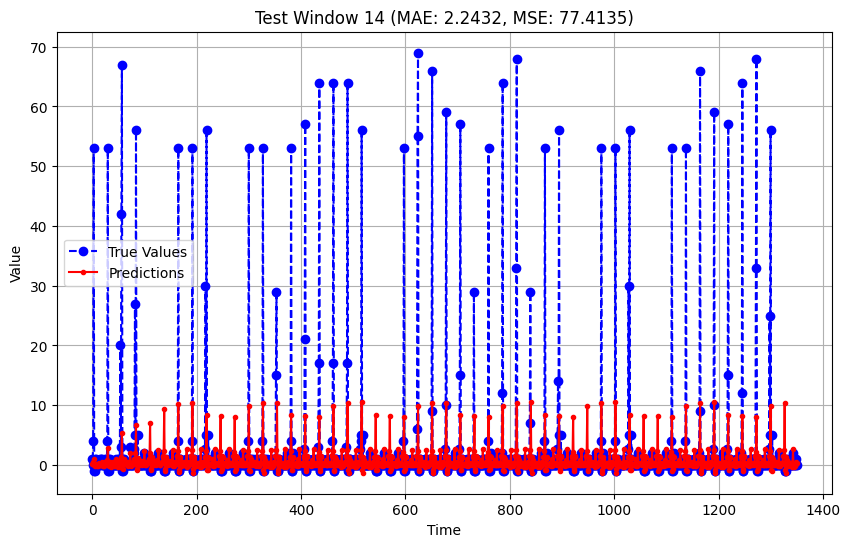

Test Window 14:
  MAE: 2.2431981563568115
  MSE: 77.41350555419922
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


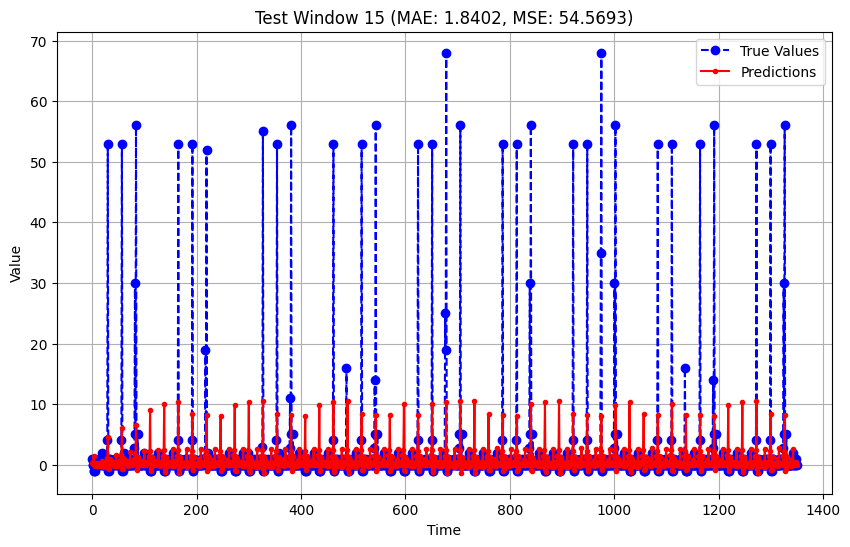

Test Window 15:
  MAE: 1.840222954750061
  MSE: 54.5693473815918
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


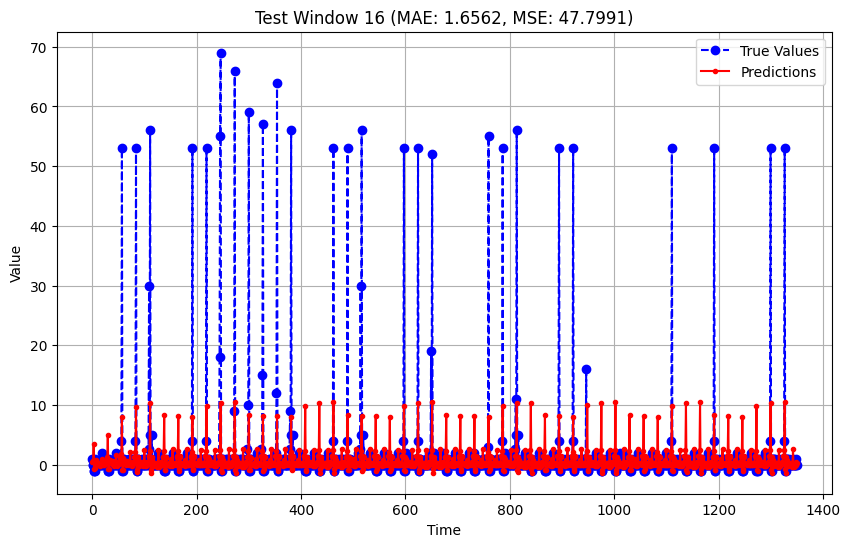

Test Window 16:
  MAE: 1.6562055349349976
  MSE: 47.79909133911133
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


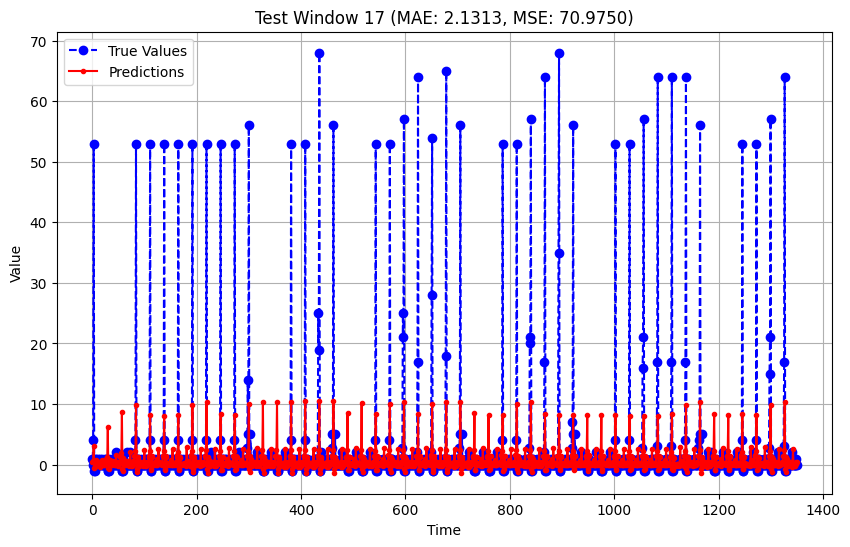

Test Window 17:
  MAE: 2.1313037872314453
  MSE: 70.97502136230469
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


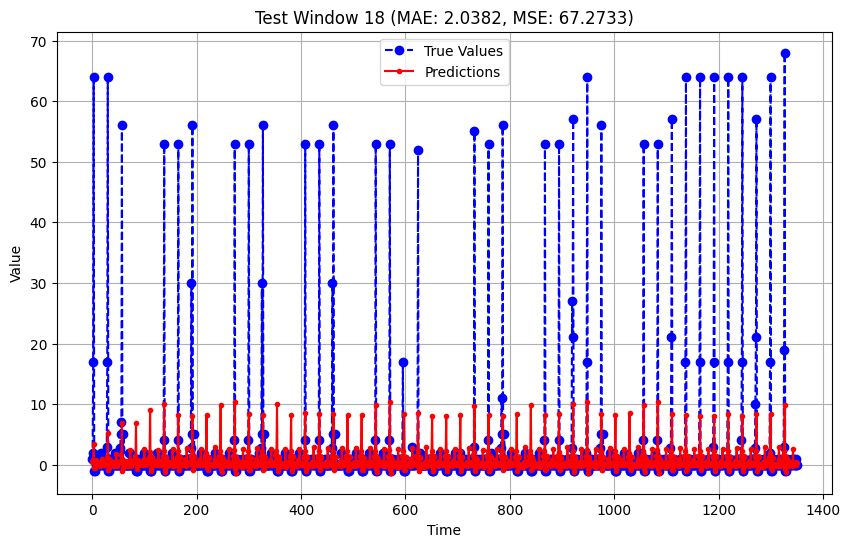

Test Window 18:
  MAE: 2.038227081298828
  MSE: 67.27332305908203
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


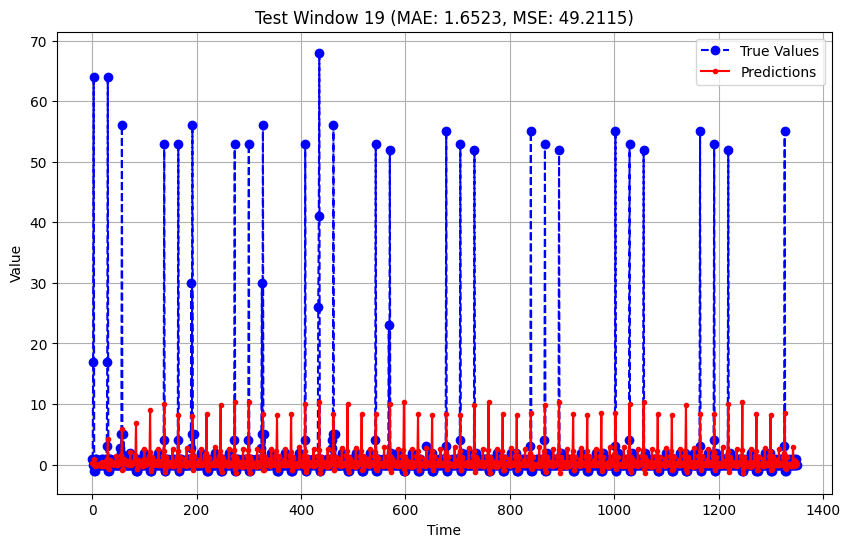

Test Window 19:
  MAE: 1.6523154973983765
  MSE: 49.21154022216797
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


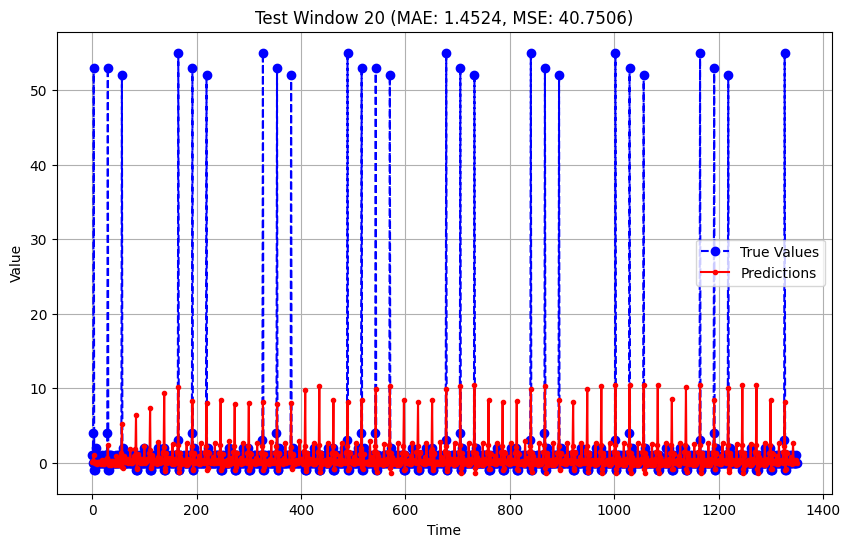

Test Window 20:
  MAE: 1.4524065256118774
  MSE: 40.75059127807617
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


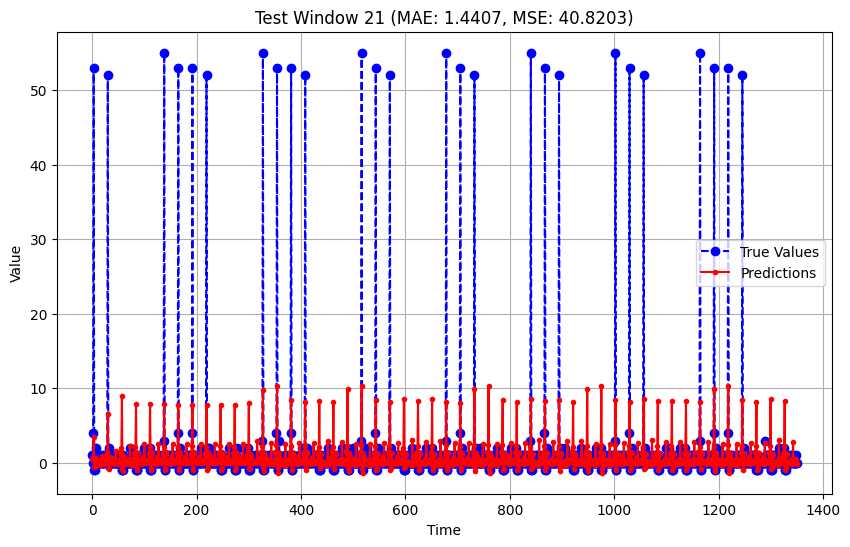

Test Window 21:
  MAE: 1.4407382011413574
  MSE: 40.82030487060547
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


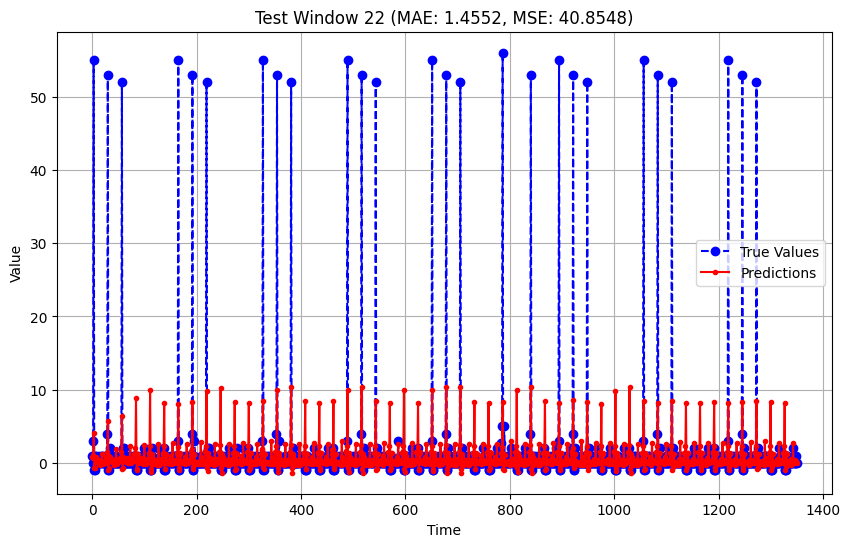

Test Window 22:
  MAE: 1.4551821947097778
  MSE: 40.854827880859375
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


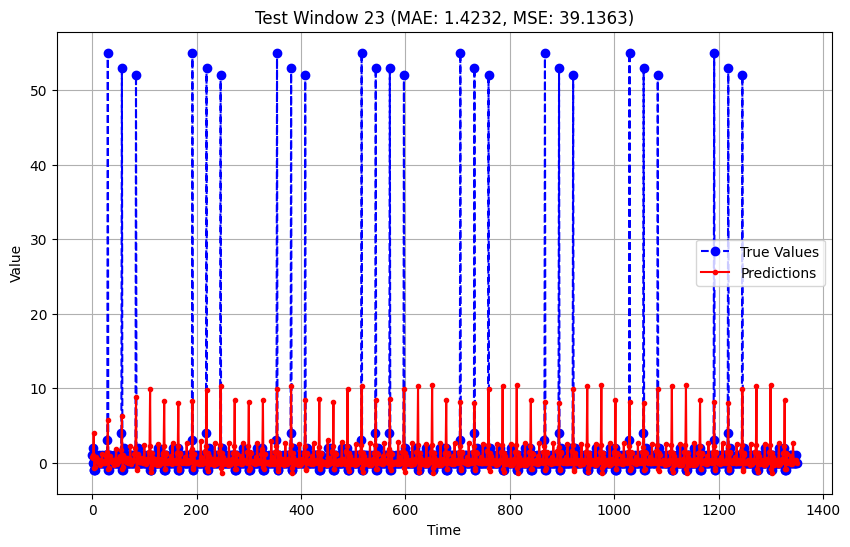

Test Window 23:
  MAE: 1.4231761693954468
  MSE: 39.13631820678711
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


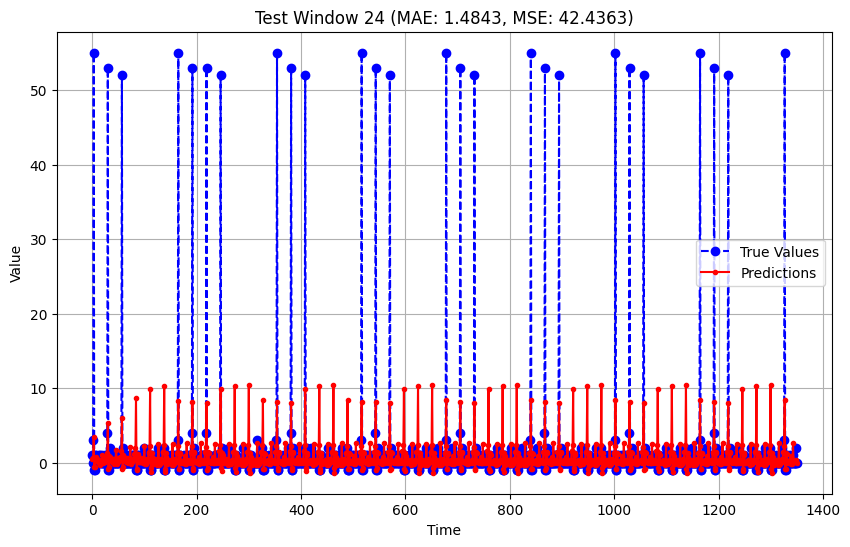

Test Window 24:
  MAE: 1.4843052625656128
  MSE: 42.43626022338867
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


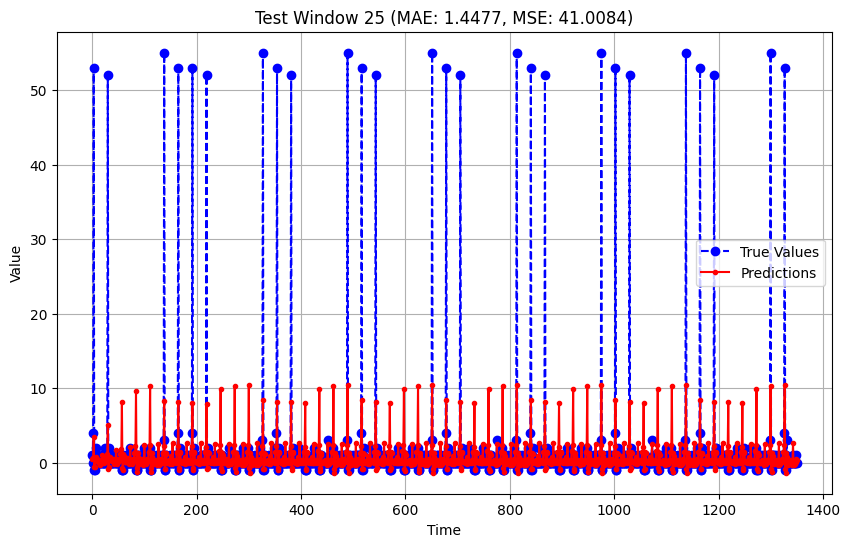

Test Window 25:
  MAE: 1.4477436542510986
  MSE: 41.008419036865234
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


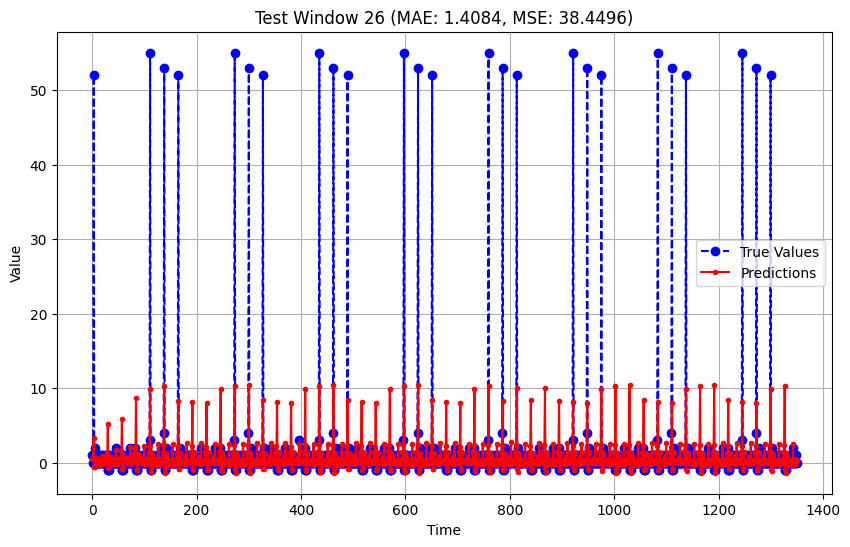

Test Window 26:
  MAE: 1.408442735671997
  MSE: 38.449642181396484
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


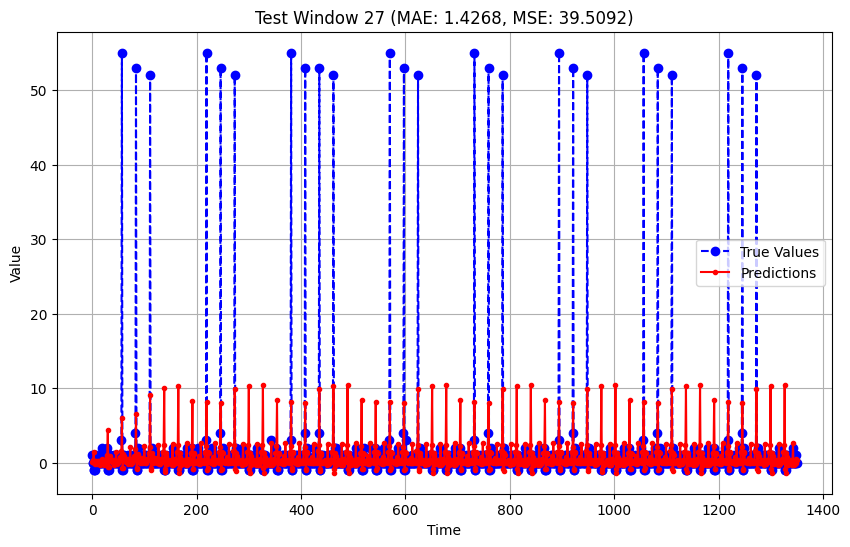

Test Window 27:
  MAE: 1.4268404245376587
  MSE: 39.50917434692383
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


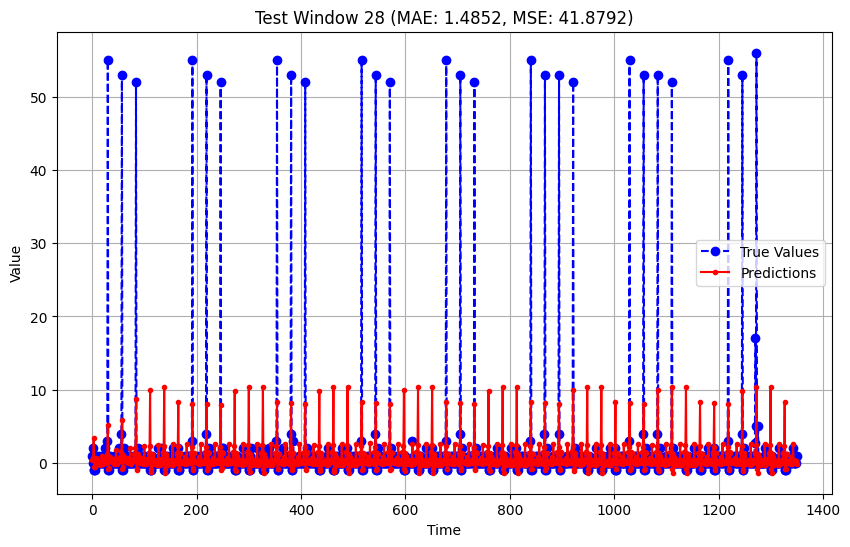

Test Window 28:
  MAE: 1.485176920890808
  MSE: 41.879154205322266
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


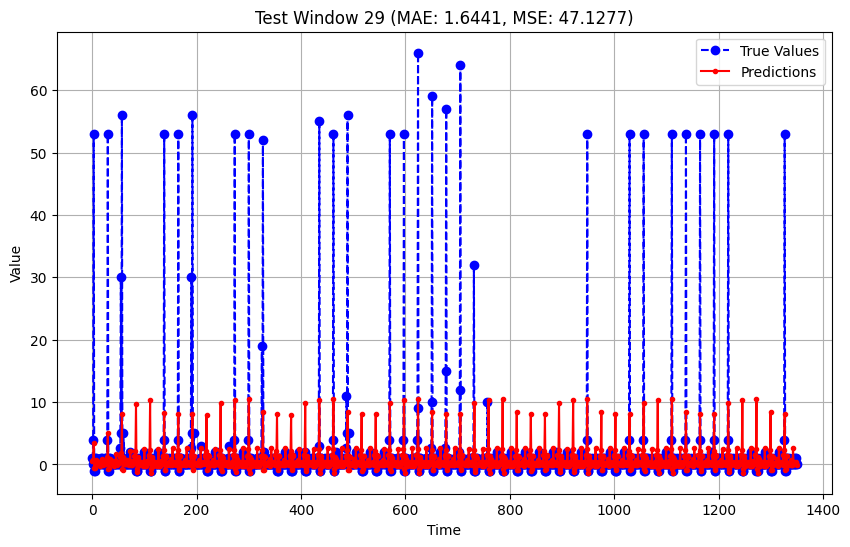

Test Window 29:
  MAE: 1.6440554857254028
  MSE: 47.127655029296875
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


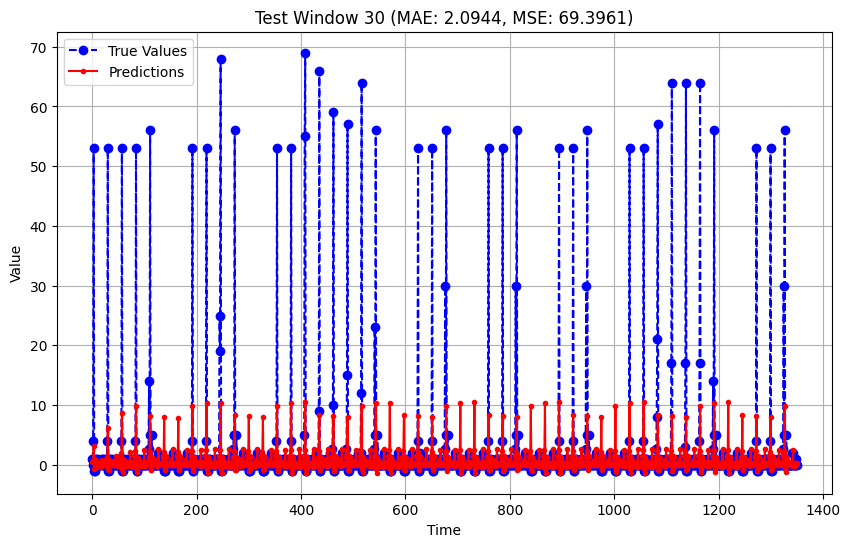

Test Window 30:
  MAE: 2.0943660736083984
  MSE: 69.39608001708984
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


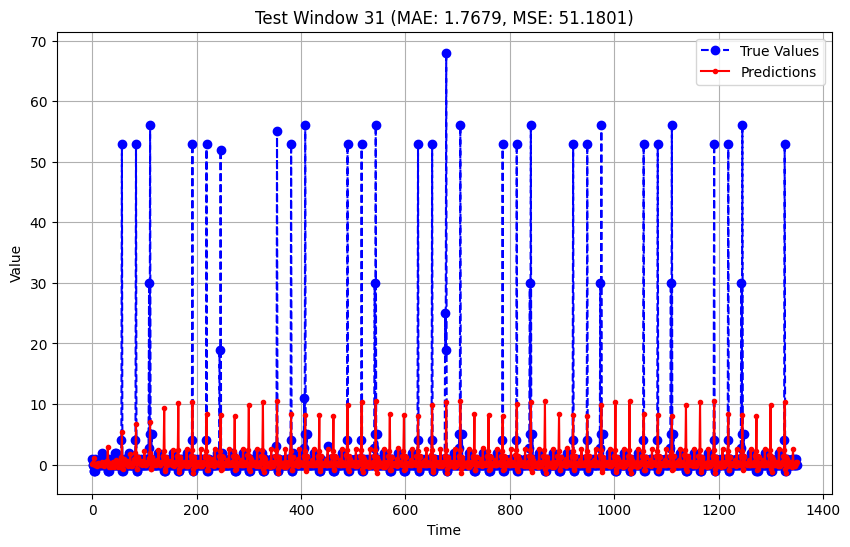

Test Window 31:
  MAE: 1.7678900957107544
  MSE: 51.18014907836914
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


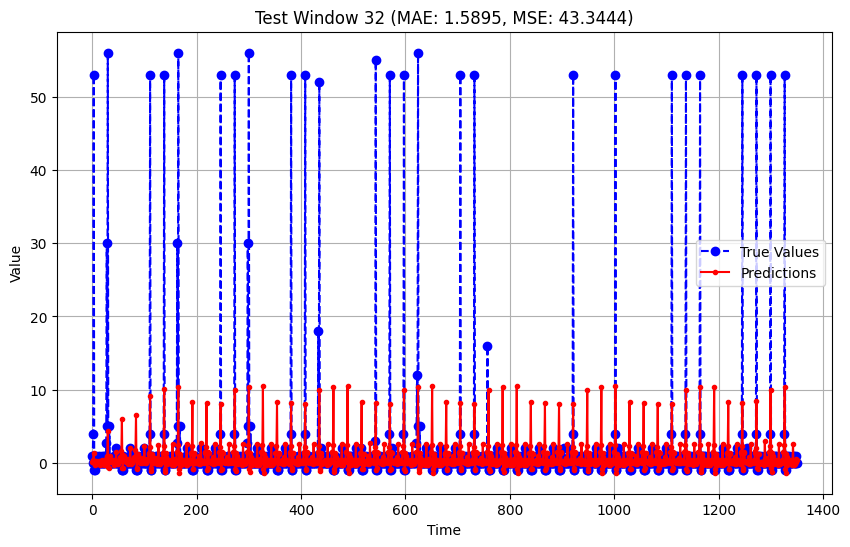

Test Window 32:
  MAE: 1.5894831418991089
  MSE: 43.34441375732422
------------------------------


In [95]:
evaluate_model_and_plot_per_window(model, test_windows, test_targets)


In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model_and_plot_per_window(model, test_windows, test_targets):
    num_windows = len(test_windows)
    for i in range(num_windows):
        # Evaluate the model on the current test window
        test_predictions = model.predict(test_windows[i:i+1])
        mae = mean_absolute_error(test_targets[i].flatten(), test_predictions.flatten())
        mse = mean_squared_error(test_targets[i].flatten(), test_predictions.flatten())

        # Print the true values and predictions for the current test window
        print(f"Test Window {i+1} - Sequence:")
        print(test_targets[i].flatten())
        print(f"Test Window {i+1} - Prediction:")
        print(test_predictions.flatten())

        # Plot true values vs predicted values for the current test window
        plt.figure(figsize=(10, 6))
        plt.plot(test_targets[i].flatten(), label='True Values', linestyle='--', marker='o', color='b')
        plt.plot(test_predictions.flatten(), label='Predictions', linestyle='-', marker='.', color='r')
        plt.title(f'Test Window {i+1} (MAE: {mae:.4f}, MSE: {mse:.4f})')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print the metrics for the current test window
        print(f"Test Window {i+1}:")
        print(f"  MAE: {mae}")
        print(f"  MSE: {mse}")
        print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 1 - Sequence:
[1. 0. 0. ... 0. 0. 0.]
Test Window 1 - Prediction:
[0.57463056 0.5947101  0.74460614 ... 0.37009642 0.07389767 0.3738485 ]


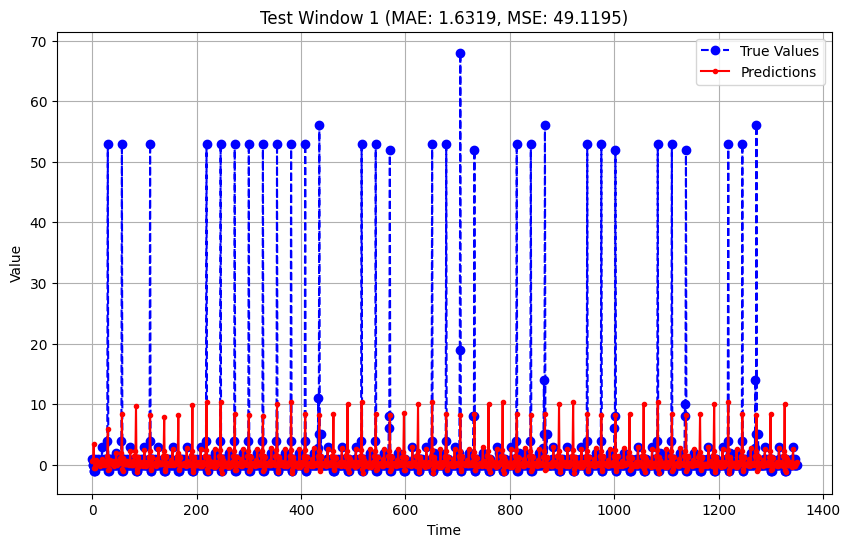

Test Window 1:
  MAE: 1.631862759590149
  MSE: 49.11945724487305
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 2 - Sequence:
[1. 0. 4. ... 0. 0. 0.]
Test Window 2 - Prediction:
[0.12854832 0.29315168 0.412926   ... 0.45933366 0.06512935 0.3612226 ]


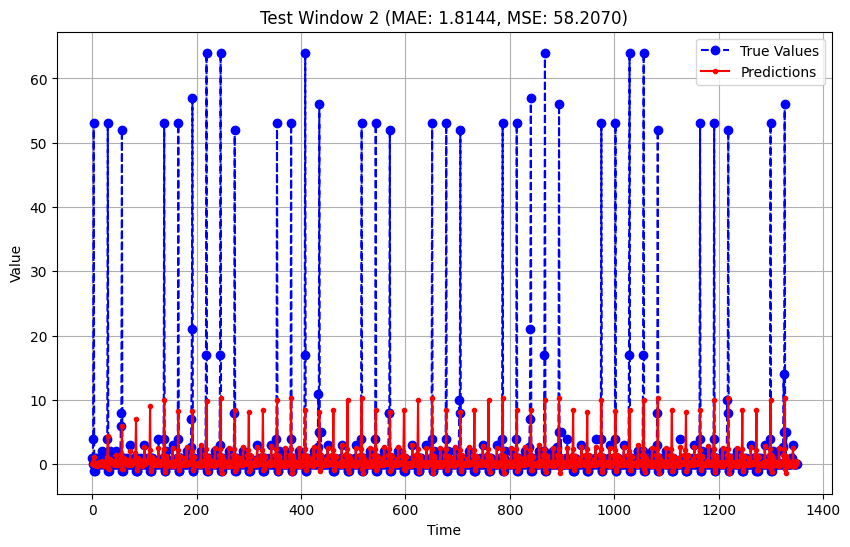

Test Window 2:
  MAE: 1.814355492591858
  MSE: 58.20698547363281
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test Window 3 - Sequence:
[1. 0. 0. ... 0. 0. 0.]
Test Window 3 - Prediction:
[0.5573114  0.5866305  0.7500116  ... 0.4152826  0.09063112 0.3445546 ]


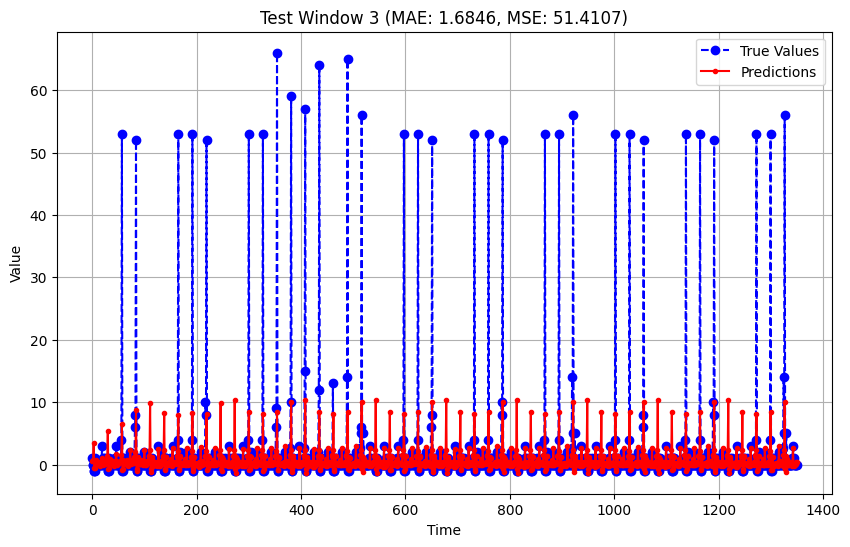

Test Window 3:
  MAE: 1.6845952272415161
  MSE: 51.41071319580078
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 4 - Sequence:
[1. 0. 0. ... 0. 0. 0.]
Test Window 4 - Prediction:
[0.18927476 0.10357945 0.42869338 ... 0.38414368 0.12846653 0.4089747 ]


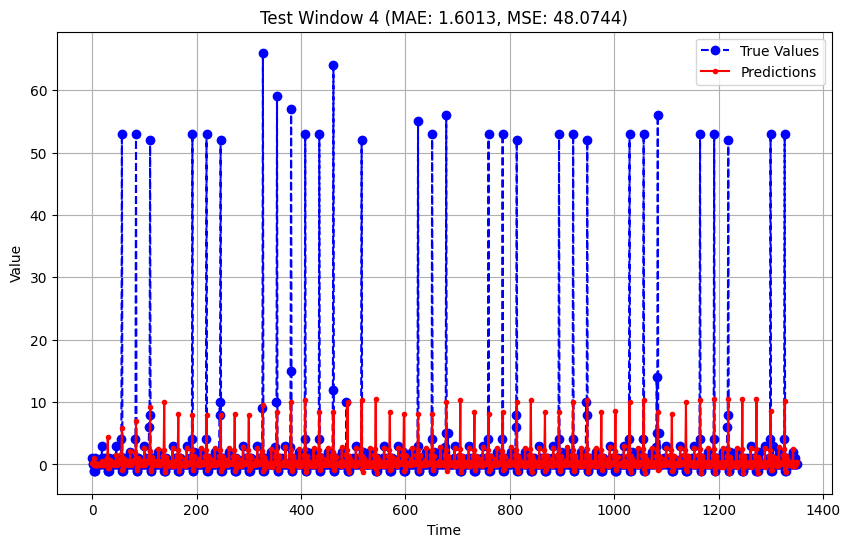

Test Window 4:
  MAE: 1.6013137102127075
  MSE: 48.074440002441406
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 5 - Sequence:
[ 1.  2. 19. ...  0.  0.  0.]
Test Window 5 - Prediction:
[0.18491398 0.10399462 0.52283394 ... 0.4441436  0.06592074 0.3845237 ]


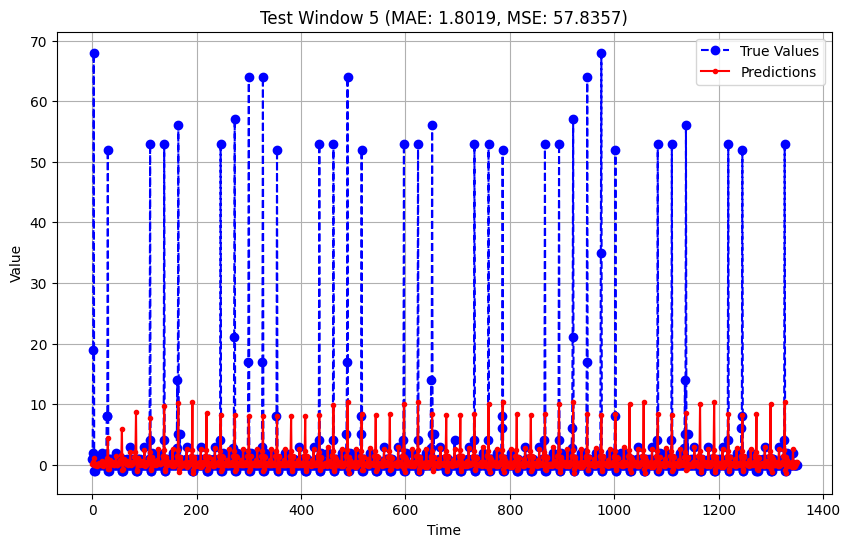

Test Window 5:
  MAE: 1.8019437789916992
  MSE: 57.83565902709961
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 6 - Sequence:
[1. 0. 4. ... 0. 0. 0.]
Test Window 6 - Prediction:
[ 0.5602827   0.58756816  0.7692371  ...  0.46174282  0.0490201
 -0.1314798 ]


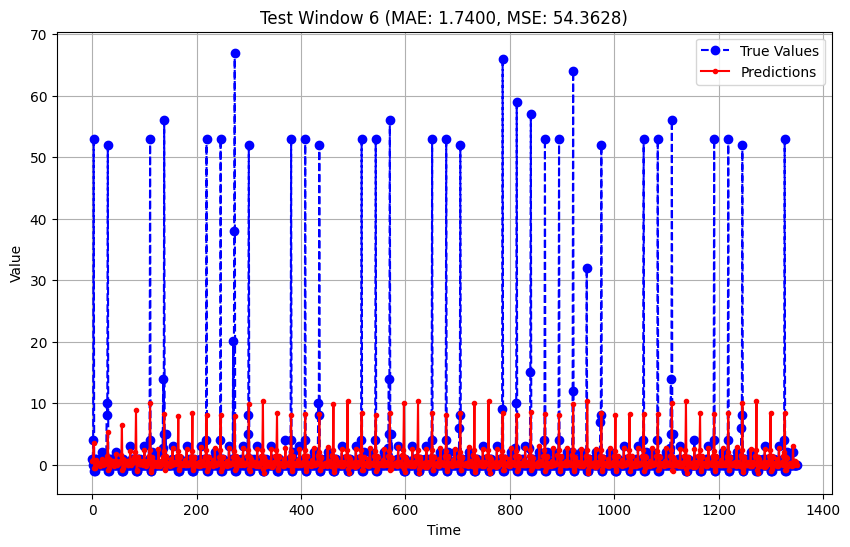

Test Window 6:
  MAE: 1.7399941682815552
  MSE: 54.36280059814453
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test Window 7 - Sequence:
[1. 0. 4. ... 0. 0. 0.]
Test Window 7 - Prediction:
[ 0.13619596  0.21494931  0.33395422 ...  0.43404484  0.00903594
 -0.1585969 ]


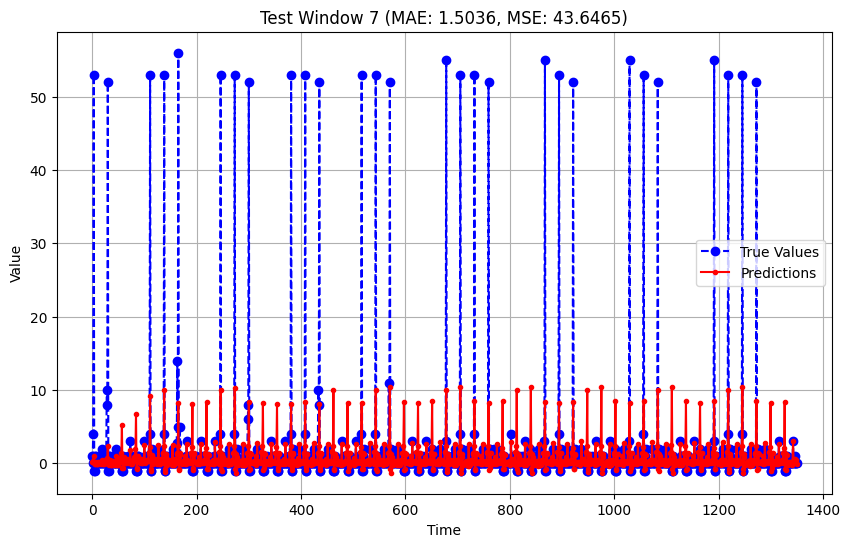

Test Window 7:
  MAE: 1.5036295652389526
  MSE: 43.64653015136719
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test Window 8 - Sequence:
[1. 1. 2. ... 0. 0. 0.]
Test Window 8 - Prediction:
[0.12357859 0.26174876 0.37947565 ... 0.16771372 0.37994602 0.00493123]


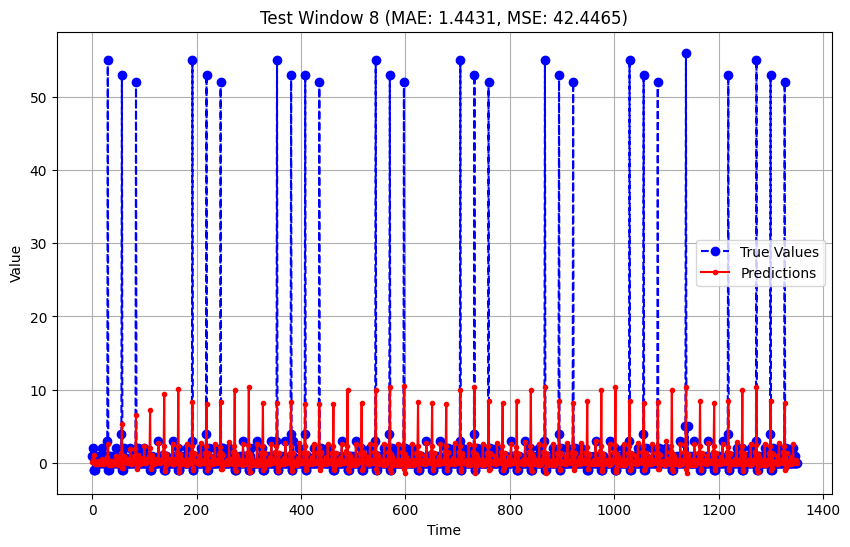

Test Window 8:
  MAE: 1.4431320428848267
  MSE: 42.446537017822266
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test Window 9 - Sequence:
[1. 0. 0. ... 0. 0. 0.]
Test Window 9 - Prediction:
[ 0.818184    0.62515163  1.06184    ...  0.17445162  0.36414862
 -0.03414495]


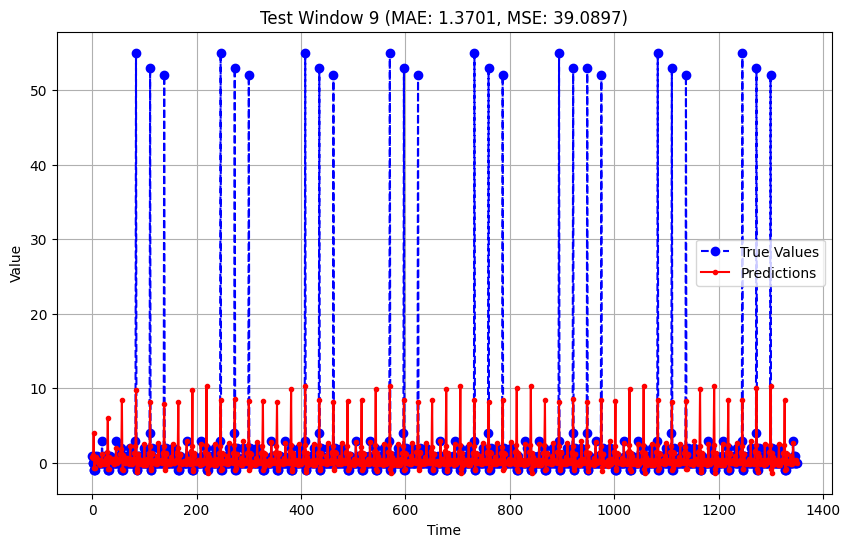

Test Window 9:
  MAE: 1.3701210021972656
  MSE: 39.08969497680664
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 10 - Sequence:
[1. 0. 0. ... 0. 0. 0.]
Test Window 10 - Prediction:
[ 0.5161369   0.6061479   0.73217225 ...  0.18229887  0.3654958
 -0.02427427]


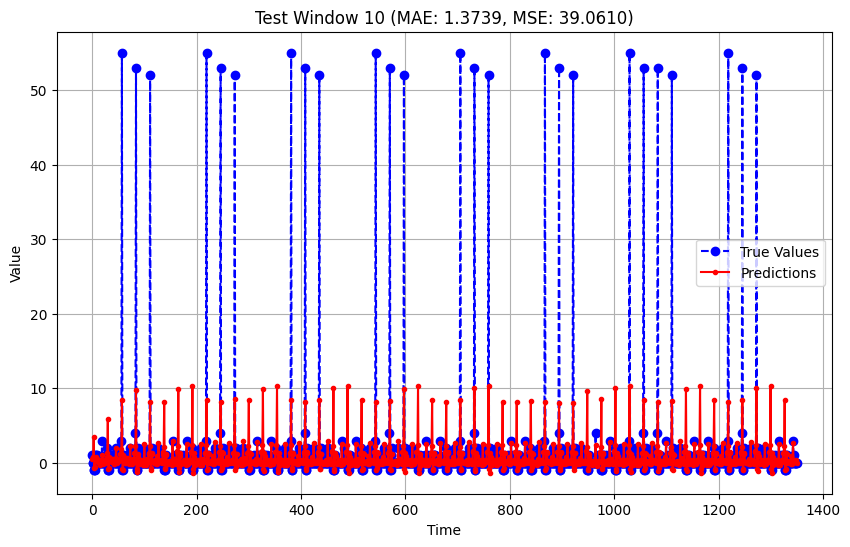

Test Window 10:
  MAE: 1.3739430904388428
  MSE: 39.060977935791016
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 11 - Sequence:
[1. 0. 2. ... 0. 0. 0.]
Test Window 11 - Prediction:
[0.54682875 0.5860155  0.74803805 ... 0.44724312 0.0808727  0.39081213]


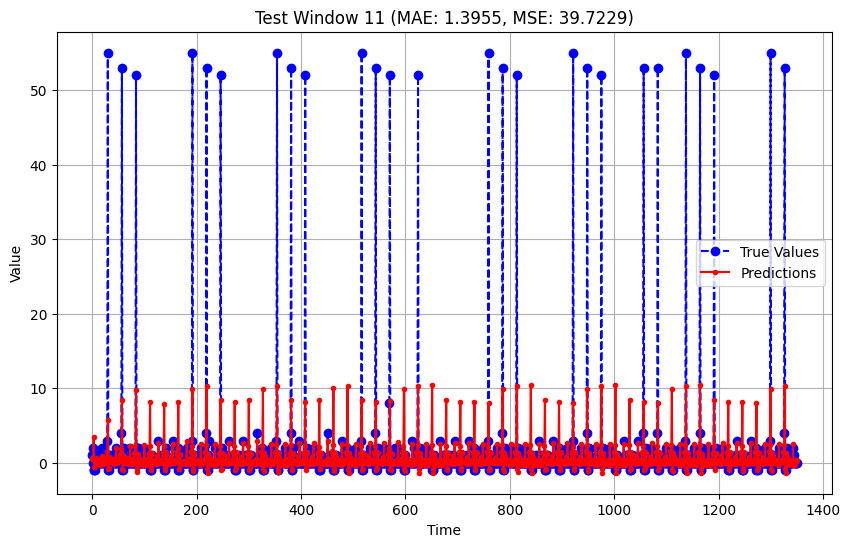

Test Window 11:
  MAE: 1.3955343961715698
  MSE: 39.72294998168945
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Window 12 - Sequence:
[1. 0. 4. ... 0. 0. 0.]
Test Window 12 - Prediction:
[ 0.17817582  0.32619047  0.34524128 ...  0.19659673  0.3553108
 -0.00530696]


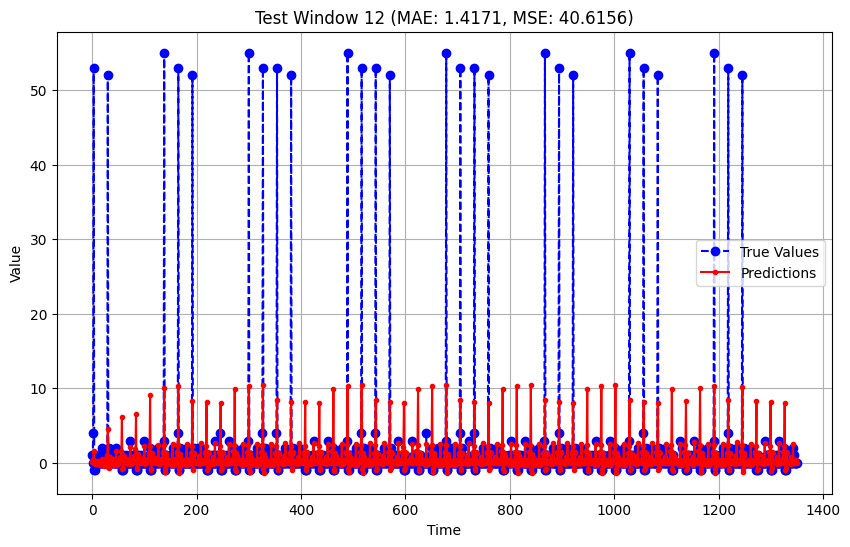

Test Window 12:
  MAE: 1.4171264171600342
  MSE: 40.6156120300293
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 13 - Sequence:
[1. 0. 1. ... 1. 0. 0.]
Test Window 13 - Prediction:
[0.18154015 0.2547382  0.38849136 ... 0.333752   0.12819797 0.38963214]


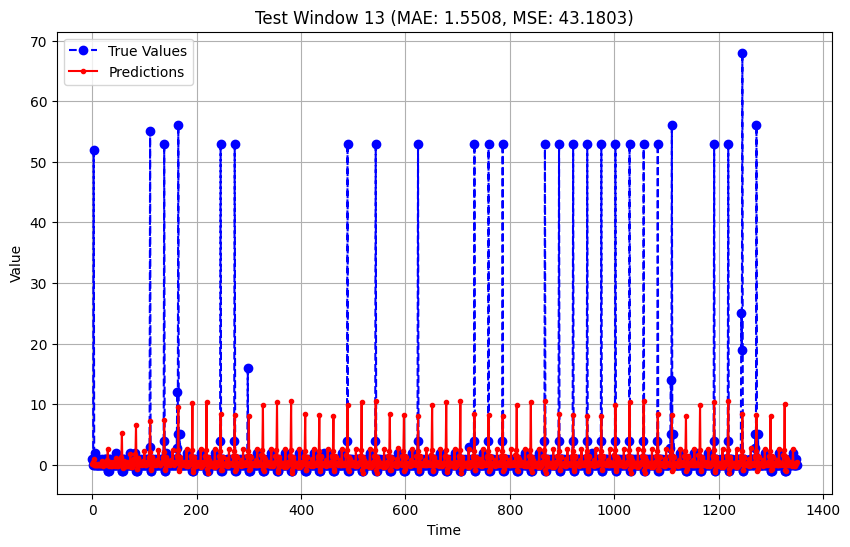

Test Window 13:
  MAE: 1.5508040189743042
  MSE: 43.18031692504883
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 14 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 14 - Prediction:
[0.17217363 0.23870543 0.41275427 ... 0.4379912  0.06952263 0.3906729 ]


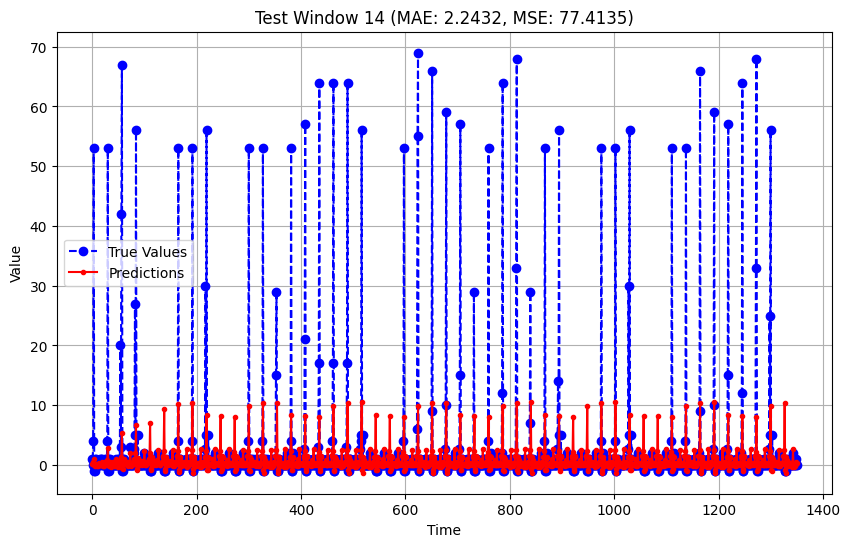

Test Window 14:
  MAE: 2.2431981563568115
  MSE: 77.41350555419922
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 15 - Sequence:
[1. 0. 0. ... 1. 0. 0.]
Test Window 15 - Prediction:
[0.20994876 0.34861955 0.40558484 ... 0.17005122 0.3815241  0.00661035]


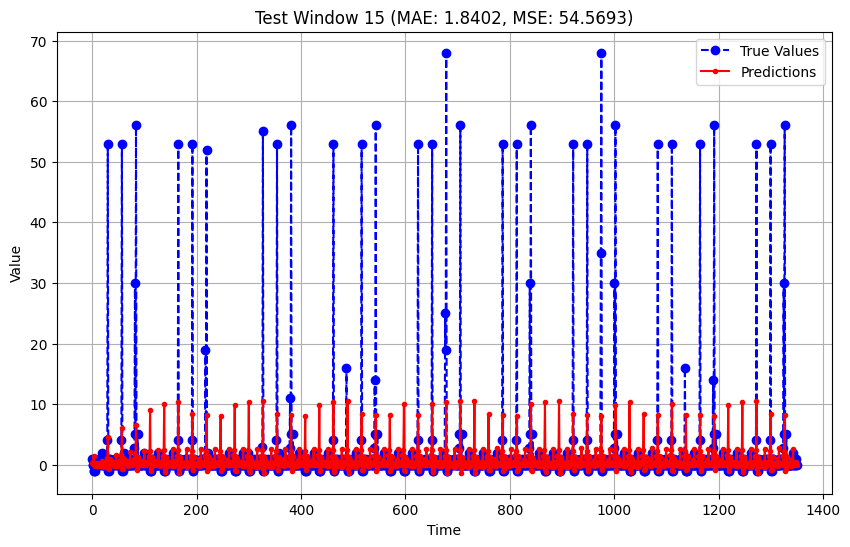

Test Window 15:
  MAE: 1.840222954750061
  MSE: 54.5693473815918
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 16 - Sequence:
[1. 0. 0. ... 1. 0. 0.]
Test Window 16 - Prediction:
[0.5199879  0.61454177 0.6856207  ... 0.42884436 0.04187774 0.37531784]


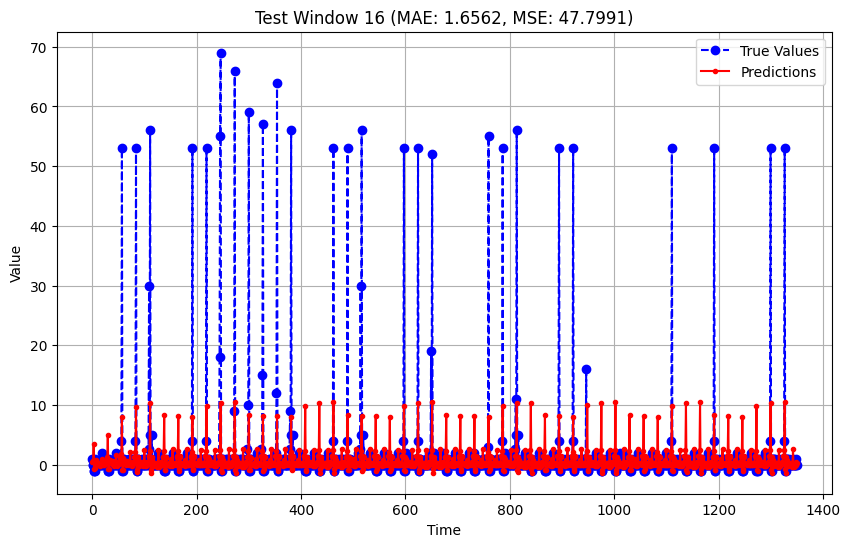

Test Window 16:
  MAE: 1.6562055349349976
  MSE: 47.79909133911133
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 17 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 17 - Prediction:
[0.44120294 0.6356107  0.5084611  ... 0.4583904  0.04278036 0.3872255 ]


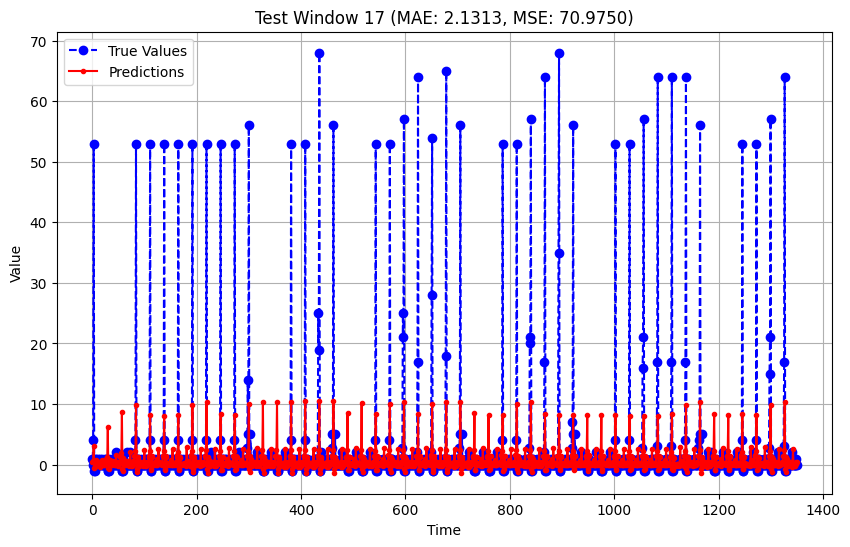

Test Window 17:
  MAE: 2.1313037872314453
  MSE: 70.97502136230469
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 18 - Sequence:
[ 1.  2. 17. ...  1.  0.  0.]
Test Window 18 - Prediction:
[0.51875705 0.61427176 0.7232746  ... 0.4236258  0.02750793 0.27685457]


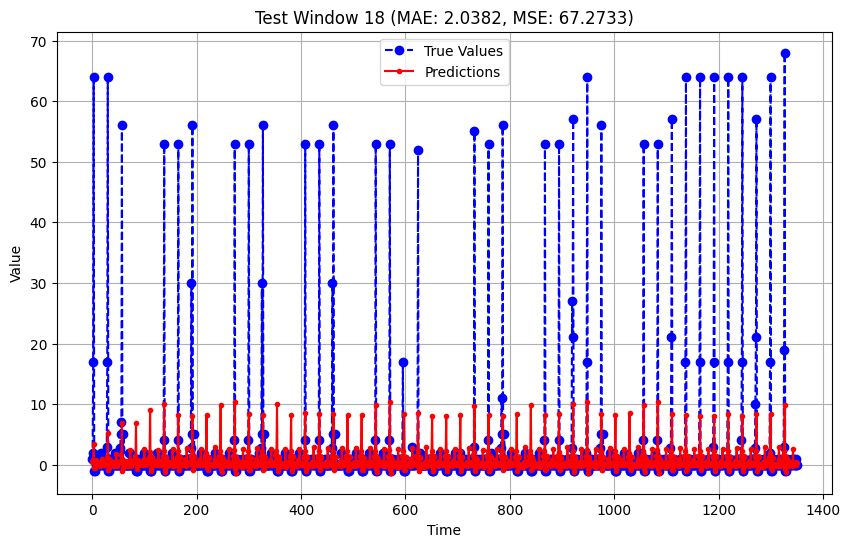

Test Window 18:
  MAE: 2.038227081298828
  MSE: 67.27332305908203
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 19 - Sequence:
[ 1.  0. 17. ...  1.  0.  0.]
Test Window 19 - Prediction:
[ 0.19432896  0.2257949   0.30215648 ...  0.36878988 -0.10893287
  0.08236389]


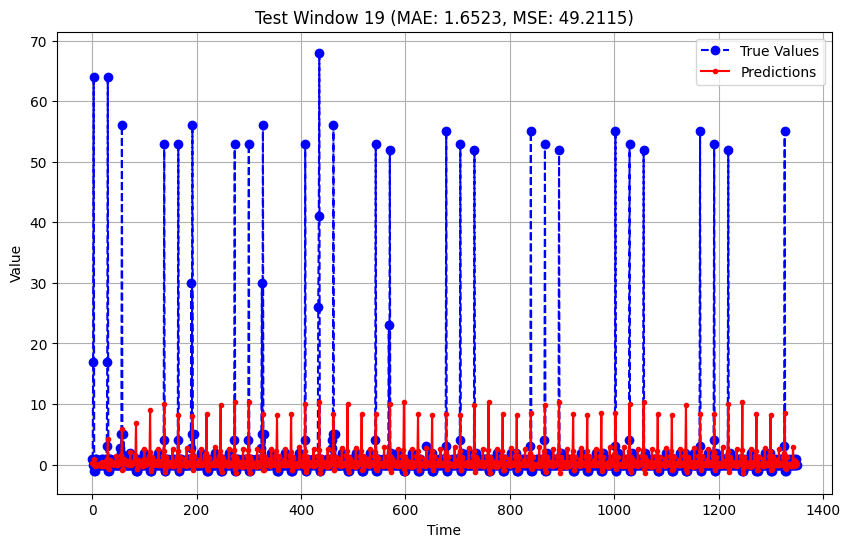

Test Window 19:
  MAE: 1.6523154973983765
  MSE: 49.21154022216797
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 20 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 20 - Prediction:
[ 0.10826813  0.2578797   0.24712512 ...  0.20885788  0.38451278
 -0.03623025]


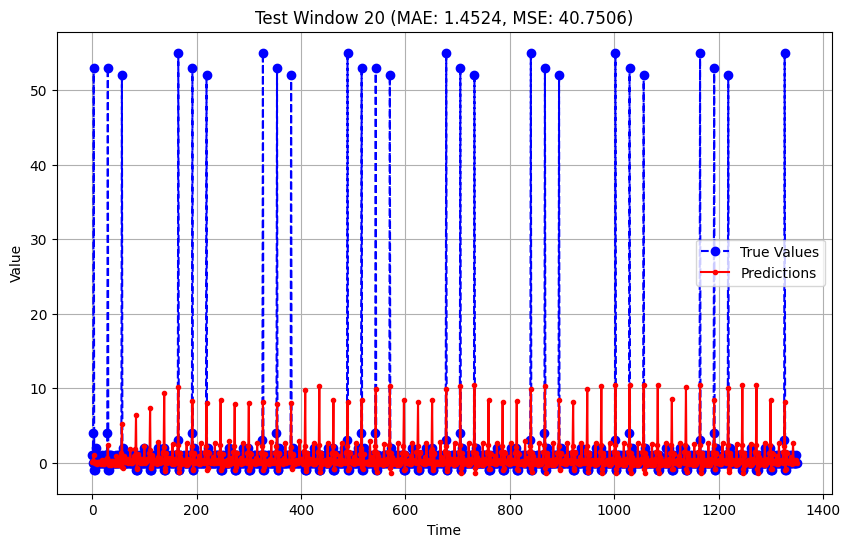

Test Window 20:
  MAE: 1.4524065256118774
  MSE: 40.75059127807617
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 21 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 21 - Prediction:
[ 0.5013384   0.5954149   0.7199781  ...  0.34180686  0.1044211
 -0.08691802]


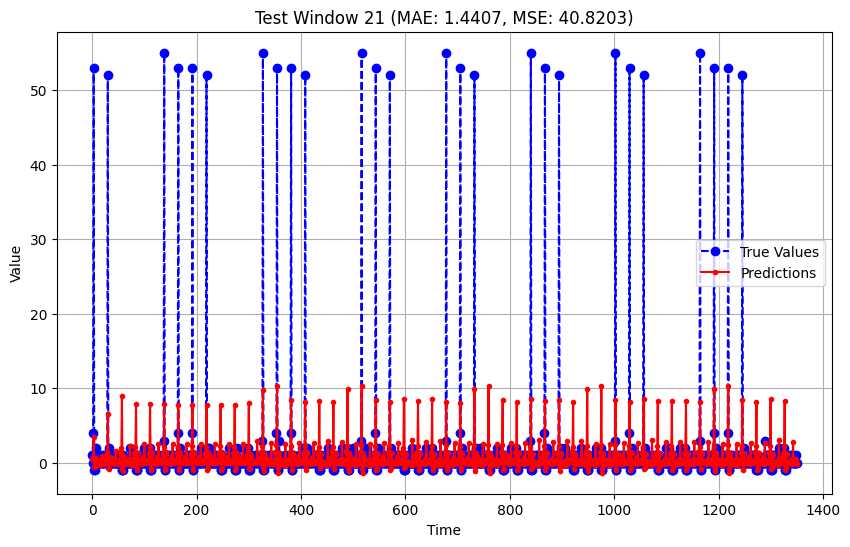

Test Window 21:
  MAE: 1.4407382011413574
  MSE: 40.82030487060547
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 22 - Sequence:
[1. 0. 3. ... 1. 0. 0.]
Test Window 22 - Prediction:
[0.7959839  0.6300867  1.0606819  ... 0.24474105 0.18195578 0.00453682]


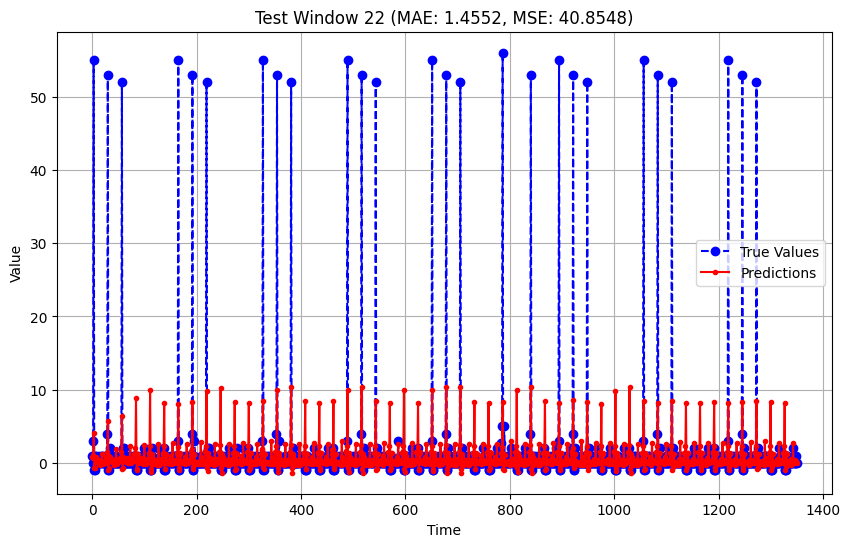

Test Window 22:
  MAE: 1.4551821947097778
  MSE: 40.854827880859375
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 23 - Sequence:
[1. 0. 2. ... 1. 0. 0.]
Test Window 23 - Prediction:
[ 0.79359317  0.61699617  1.0102906  ...  0.21496208  0.34858277
 -0.0623965 ]


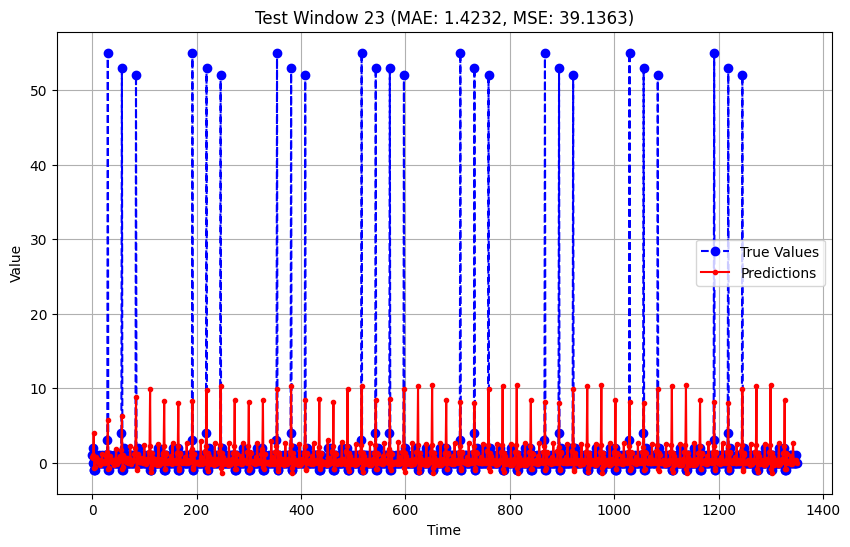

Test Window 23:
  MAE: 1.4231761693954468
  MSE: 39.13631820678711
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 24 - Sequence:
[1. 0. 3. ... 2. 0. 0.]
Test Window 24 - Prediction:
[ 0.53907204  0.6496041   0.68370116 ...  0.20006722  0.33719766
 -0.06018633]


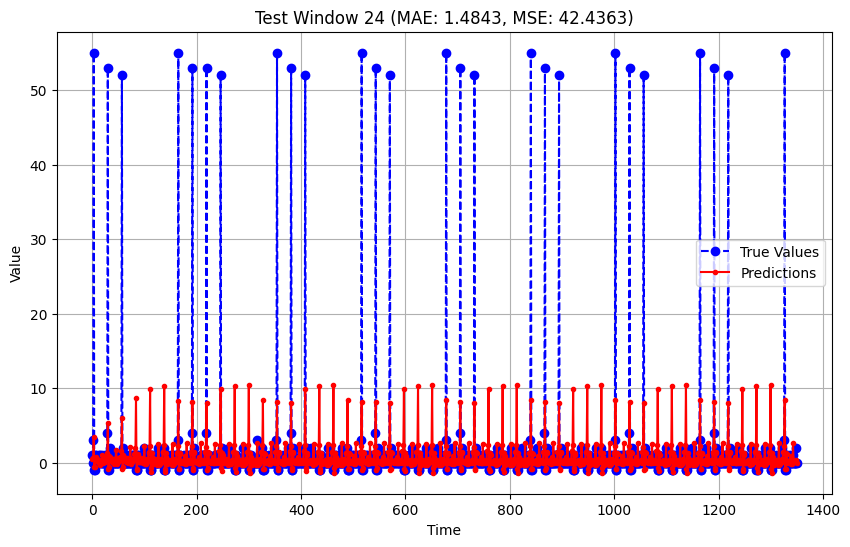

Test Window 24:
  MAE: 1.4843052625656128
  MSE: 42.43626022338867
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 25 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 25 - Prediction:
[0.5222526  0.6485017  0.6755347  ... 0.45988384 0.04869852 0.36390376]


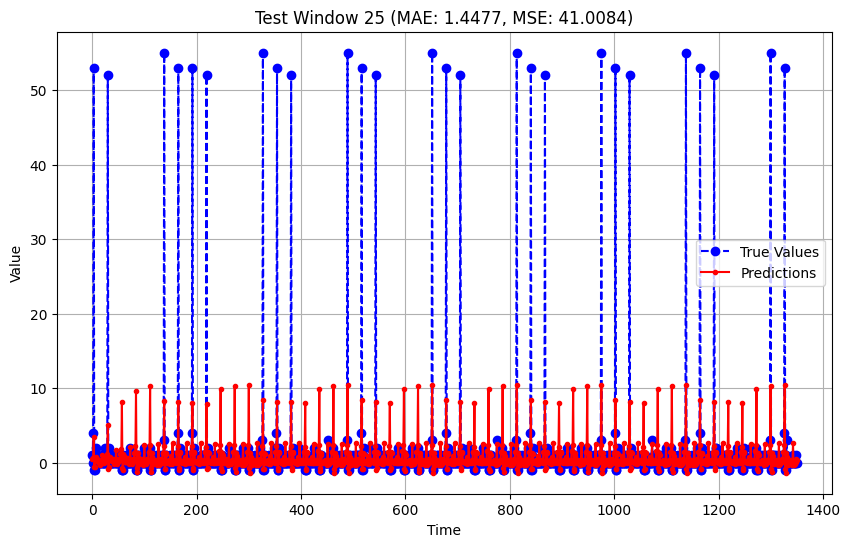

Test Window 25:
  MAE: 1.4477436542510986
  MSE: 41.008419036865234
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 26 - Sequence:
[1. 0. 1. ... 1. 0. 0.]
Test Window 26 - Prediction:
[0.5250438  0.61383724 0.6789386  ... 0.4605592  0.05817052 0.37799546]


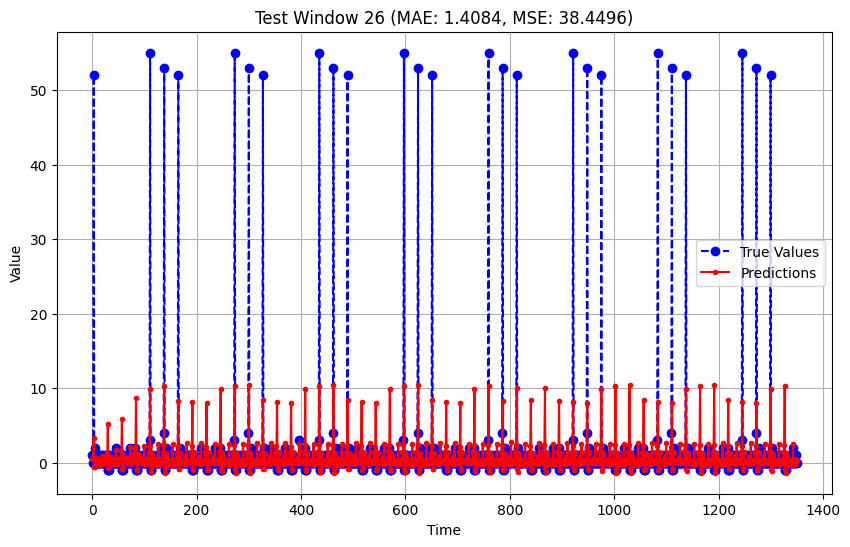

Test Window 26:
  MAE: 1.408442735671997
  MSE: 38.449642181396484
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 27 - Sequence:
[1. 0. 0. ... 1. 0. 0.]
Test Window 27 - Prediction:
[0.16654336 0.40667978 0.311174   ... 0.45768085 0.03386023 0.37720615]


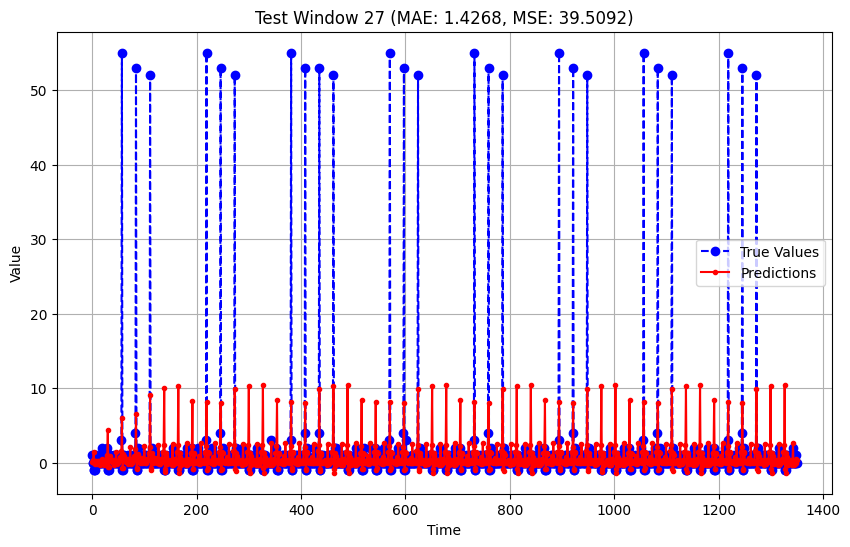

Test Window 27:
  MAE: 1.4268404245376587
  MSE: 39.50917434692383
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 28 - Sequence:
[1. 0. 2. ... 1. 0. 1.]
Test Window 28 - Prediction:
[ 0.47983748  0.61282635  0.6799126  ...  0.24504842  0.32282975
 -0.07294527]


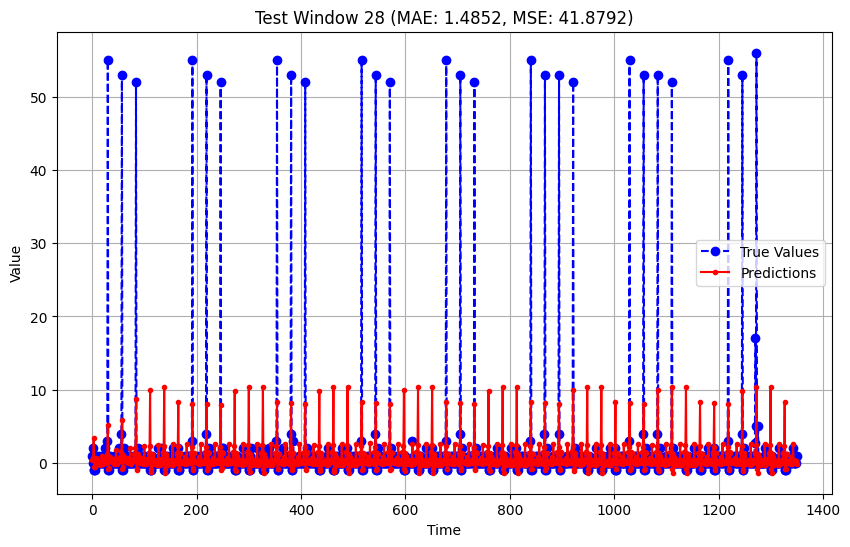

Test Window 28:
  MAE: 1.485176920890808
  MSE: 41.879154205322266
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 29 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 29 - Prediction:
[ 0.5091903   0.63867027  0.6572792  ...  0.21745372  0.361519
 -0.03154596]


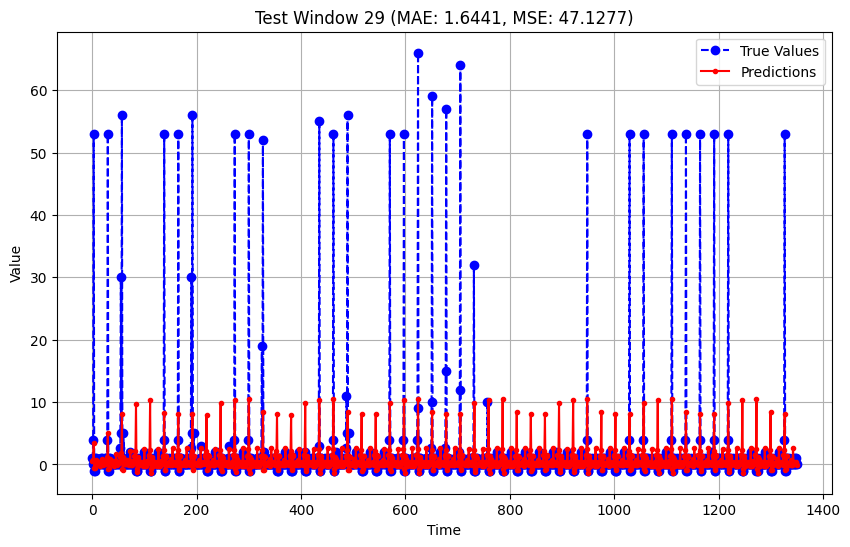

Test Window 29:
  MAE: 1.6440554857254028
  MSE: 47.127655029296875
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Window 30 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 30 - Prediction:
[0.48335198 0.60455126 0.5987452  ... 0.3761819  0.11143567 0.36529258]


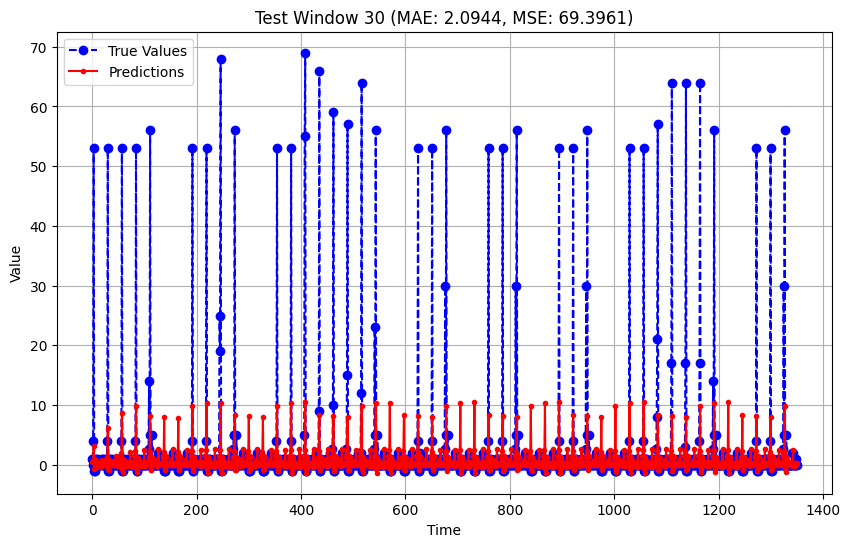

Test Window 30:
  MAE: 2.0943660736083984
  MSE: 69.39608001708984
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Window 31 - Sequence:
[1. 0. 0. ... 1. 0. 0.]
Test Window 31 - Prediction:
[0.10258538 0.23773322 0.27776584 ... 0.4697693  0.06045796 0.36964765]


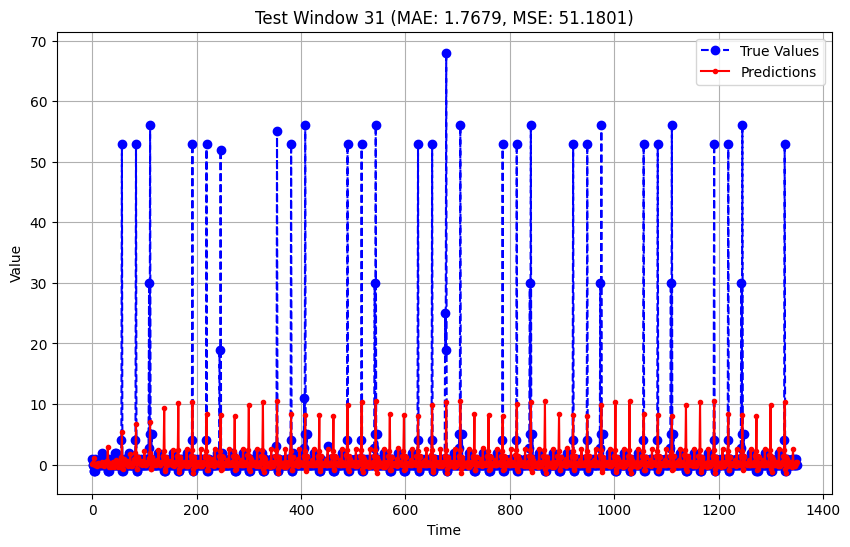

Test Window 31:
  MAE: 1.7678900957107544
  MSE: 51.18014907836914
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Window 32 - Sequence:
[1. 0. 4. ... 1. 0. 0.]
Test Window 32 - Prediction:
[0.09885268 0.43462956 0.24745056 ... 0.4722795  0.06698337 0.38159466]


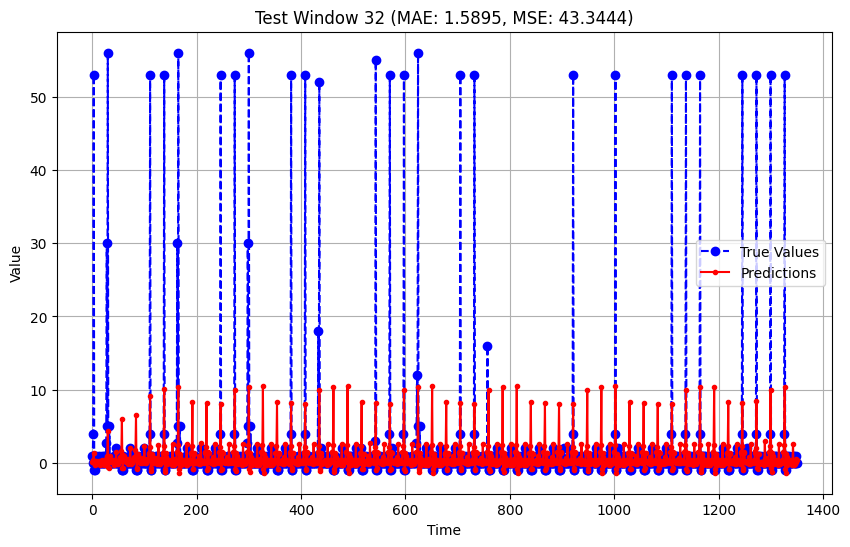

Test Window 32:
  MAE: 1.5894831418991089
  MSE: 43.34441375732422
------------------------------


In [97]:
evaluate_model_and_plot_per_window(model, test_windows, test_targets)
